# **Modelo de Atribución Publicitaria y Predicción de Ventas en Retail Omnicanal.**
Este análisis tiene como objetivo construir un **modelo de atribución** de marketing para una empresa de retail de gran consumo, en el contexto de una estrategia omnicanal con fuerte componente digital. El propósito es **comprender el impacto de las distintas partidas presupuestarias** (agrupadas por tipo de canal) y el **tráfico web en las ventas físicas** realizadas en tienda.

Se utilizará un enfoque de regresión lineal múltiple, integrando variables de calendario y un retardo temporal (delay $t-1$) en las inversiones y el tráfico digital, para reflejar la lógica temporal real de influencia. Finalmente, el modelo se aplicará a un escenario simulado con el fin de optimizar la asignación de presupuesto publicitario.

## **Descripción.**
Este análisis tiene como objetivo desarrollar un modelo de atribución publicitaria capaz de estimar el impacto de las diferentes inversiones de marketing en las ventas físicas de una empresa de retail omnicanal.

La empresa combina canales online y offline en su estrategia comercial, por lo que es crucial entender cómo interactúan la inversión publicitaria, el tráfico web y las ventas en tienda. Además, se busca generar una herramienta que permita simular escenarios futuros y optimizar la asignación del presupuesto publicitario.

Para ello se construirá un modelo de regresión múltiple que:
- Integre las inversiones agrupadas por canal (Online, Offline, Otros),
- Considere el efecto del tráfico digital (`Unique_visitors`) como puente entre marketing y ventas,
- Aplique un retardo de 1 mes ($t-1$) a las variables de marketing, en línea con la lógica de negocio,
- Incorpore factores de calendario (días laborables, fines de semana, eventos comerciales),
- Sea capaz de generar predicciones y facilitar la toma de decisiones estratégicas de inversión.

Este análisis se enmarca dentro del segundo objetivo del caso de uso MMM (Marketing Mix Modeling).

## **Importación de librerías.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
import pandas as pd
import os
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
import json
import warnings
import calendar

warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_columns', None)

## **Importación e información de Dataframes.**
En este apartado se realizará la carga de las diferentes tablas necesarias para la prediccón del tráfico web en el sector retail del caso de uso. La información proviene de dos posibles fuentes:

1. **Archivos locales (.csv)**: Para agilizar el proceso y evitar conexiones innecesarias a la base de datos, se verificará si los datos ya se encuentran almacenados localmente en la carpeta `../data/raw`. En caso afirmativo, los archivos serán importados directamente desde dicha ruta.

2. **Base de datos Azure SQL**: Si los archivos locales no existen, se establecerá una conexión con la base de datos **usecases** ubicada en el servidor de Azure proporcionado. Las tablas serán consultadas, descargadas y guardadas en la carpeta local para su uso posterior.

Este enfoque permite optimizar el flujo de trabajo, evitando sobrecargar el servidor y asegurando que los datos queden disponibles para futuros análisis sin necesidad de realizar nuevas consultas.

In [2]:
# Configuración de conexión a Azure SQL.
server = os.getenv("SERVER", "")
database = os.getenv("DATABASE", "")
driver = '{ODBC Driver 17 for SQL Server}'
conn_str = f"DRIVER={driver};SERVER={server};DATABASE={database};Authentication=ActiveDirectoryInteractive"

In [3]:
# Rutas locales.
data_path = '../data/raw/'
files = {
    'all': 'MMM00_ALL.csv',
    'query': 'join_data.sql',
}

In [4]:
# Función para cargar desde local o Azure.
def load_data(table_key):
    file_path = os.path.join(data_path, files['all'])
    sql_path = os.path.join('../sql/', files['query'])

    if os.path.exists(file_path):
        print(f'Cargando {files["all"]} desde local...')
        df = pd.read_csv(file_path, decimal=',')
    else:
        if not os.path.exists(sql_path):
            raise FileNotFoundError(f"No se encontró el archivo SQL en {sql_path}")
        with open(sql_path, 'r') as file:
            query = file.read()

        print(f'Ejecutando consulta desde {files["query"]} y cargando desde Azure...')
        conn = pyodbc.connect(conn_str)
        df = pd.read_sql(query, conn)
        df.to_csv(file_path, index=False)
        print(f'Datos guardados en {file_path}')
    return df

In [5]:
# Cargar tablas.
df = load_data('all')

Cargando MMM00_ALL.csv desde local...


In [6]:
df.head()

,ID_Date,Unique_visitors,SocialNetworks,DirectTraffic,OnlineMedia,Visit_Store,Sales,Dias_mes,Dia_inicio_mes,Dia_findemes,working_days,Dias_fines_semana,Easterweek,CINE,EXTERIOR,INTERNET,PRENSA,PRODUCCION,RADIO,REVISTAS,PlataformasVideo,VARIOS
0,202201,272382,1415,65373,63649,5516,1299,31,5,7,21,10,0,59887.84,8200.00,133666.43,0.0,6050.0,2426.40,18013.50,338824.94,7531.03
1,202202,352581,546,77209,124861,6769,1752,28,1,7,20,8,0,72291.56,94627.51,189275.94,10000.0,6700.0,0.00,49110.91,487537.14,6972.02
2,202203,332955,5444,83178,104132,6249,1897,31,1,3,23,8,0,55000.00,0.00,214037.62,4500.0,3700.0,0.00,0.00,75000.00,15284.85
3,202204,282169,1184,69335,74044,6507,1546,30,4,5,22,8,1,10883.30,0.00,194816.97,48800.0,21550.0,1140.00,40876.00,610865.89,12255.75
4,202205,261829,8648,70972,44196,7183,1784,31,6,1,21,10,0,74333.20,0.00,130795.16,11000.0,4900.0,102851.86,20775.75,393807.74,7926.46


In [7]:
df.tail()

,ID_Date,Unique_visitors,SocialNetworks,DirectTraffic,OnlineMedia,Visit_Store,Sales,Dias_mes,Dia_inicio_mes,Dia_findemes,working_days,Dias_fines_semana,Easterweek,CINE,EXTERIOR,INTERNET,PRENSA,PRODUCCION,RADIO,REVISTAS,PlataformasVideo,VARIOS
31,202408,252850,2402,112416,13810,7218,2202,31,2,4,23,8,0,61301.520,0.0,92527.74000,0.00000,0.0,0.0,10388.2500,381489.700,2200.7700
32,202409,236865,1566,107521,5450,6540,1641,30,5,6,21,9,0,53826.135,0.0,136639.27375,4218.59375,1987.5,0.0,8346.9625,428503.335,4811.9725
33,202410,244208,1726,100345,22472,6243,1863,31,2,4,23,8,0,46435.000,0.0,105945.00000,2867.00000,497.0,0.0,5684.0000,415964.000,5400.0000
34,202411,247005,1939,105747,19585,6469,1883,30,5,5,21,9,0,40391.000,0.0,99600.00000,2334.00000,621.0,0.0,7105.0000,308556.000,4382.0000
35,202412,245232,1908,106507,15329,6618,1897,31,7,6,22,9,0,50488.000,0.0,108678.00000,2355.00000,776.0,0.0,7881.0000,383628.000,4199.0000


In [8]:
# Convertir fechas de formato YYYYMM a fecha con día 1 del mes.
df['ID_Date'] = pd.to_datetime(df['ID_Date'].astype(str), format='%Y%m')

# Establecer la columna de fecha como índice.
df.set_index('ID_Date', inplace=True)

In [9]:
df.columns

Index(['Unique_visitors', 'SocialNetworks', 'DirectTraffic', 'OnlineMedia',
       'Visit_Store', 'Sales', 'Dias_mes', 'Dia_inicio_mes', 'Dia_findemes',
       'working_days', 'Dias_fines_semana', 'Easterweek', 'CINE', 'EXTERIOR',
       'INTERNET', 'PRENSA', 'PRODUCCION', 'RADIO', 'REVISTAS',
       'PlataformasVideo', 'VARIOS'],
      dtype='object')

In [10]:
df.dtypes

Unique_visitors        int64
SocialNetworks         int64
DirectTraffic          int64
OnlineMedia            int64
Visit_Store            int64
Sales                  int64
Dias_mes               int64
Dia_inicio_mes         int64
Dia_findemes           int64
working_days           int64
Dias_fines_semana      int64
Easterweek             int64
CINE                 float64
EXTERIOR             float64
INTERNET             float64
PRENSA               float64
PRODUCCION           float64
RADIO                float64
REVISTAS             float64
PlataformasVideo     float64
VARIOS               float64
dtype: object

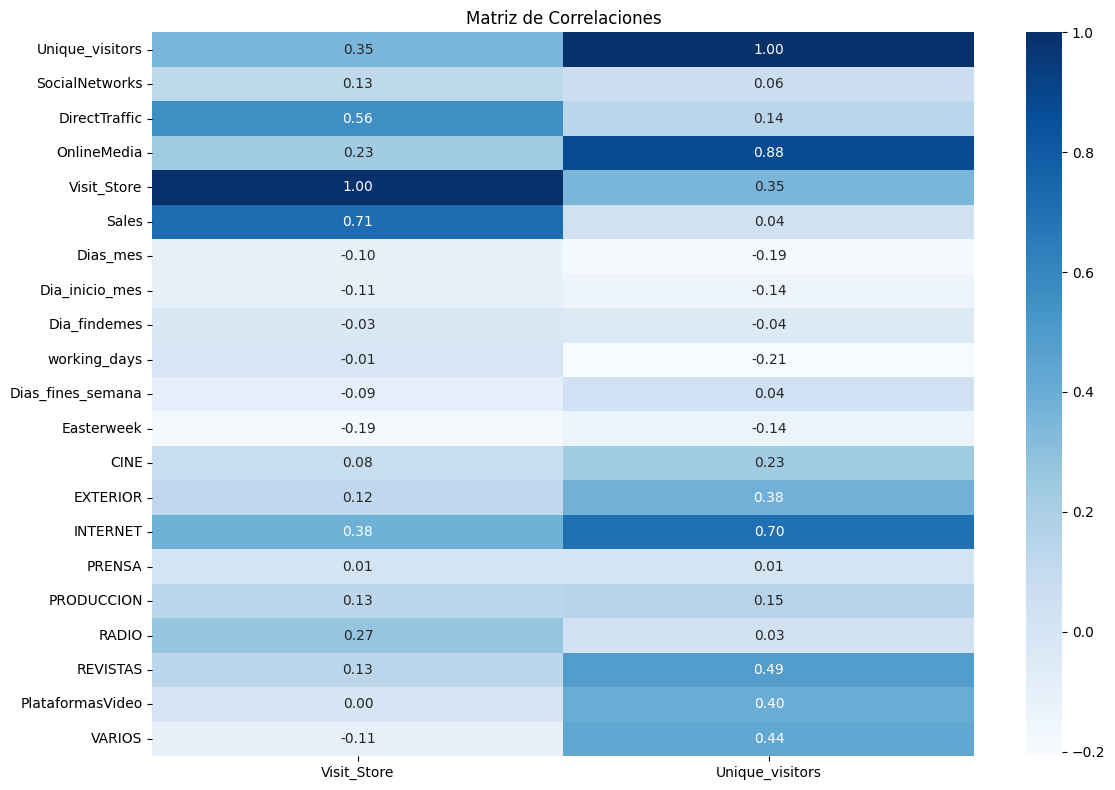

In [11]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix[['Visit_Store', 'Unique_visitors']], annot=True, cmap="Blues", fmt=".2f")
plt.title("Matriz de Correlaciones")
plt.tight_layout()
plt.show()

### **Construcción de variables clave.**
En esta sección se construyen las variables explicativas principales que alimentarán el modelo de regresión. Las inversiones publicitarias se han agrupado por tipo de canal, con base en la clasificación propuesta:

- **Online**: Suma de `INTERNET` y `PlataformasVideo`.
- **Offline**: Suma de `RADIO`, `PRENSA`, `CINE`, `REVISTAS` y `EXTERIOR`.
- **Otros**: Suma de `PRODUCCION` y `VARIOS`.

Esta agrupación facilita la interpretación de los efectos de los grandes bloques de inversión sobre el comportamiento físico del consumidor y permite al modelo identificar más claramente qué canales publicitarios tienen mayor relevancia en la generación de tráfico a tienda.

In [12]:
# Agrupación de datos.
df["Budget_Online"] = (df["INTERNET"] + df['PlataformasVideo'])
df["Budget_Offline"] = (df["RADIO"] + df["PRENSA"] + df["REVISTAS"] + df["EXTERIOR"] + df["CINE"])
df["Budget_Otros"] = (df["PRODUCCION"] + df["VARIOS"])

In [13]:
df[["Budget_Online", "Budget_Offline", "Budget_Otros"]].head()

,Budget_Online,Budget_Offline,Budget_Otros
ID_Date,,,
2022-01-01,472491.37,88527.74,13581.03
2022-02-01,676813.08,226029.98,13672.02
2022-03-01,289037.62,59500.00,18984.85
2022-04-01,805682.86,101699.30,33805.75
2022-05-01,524602.90,208960.81,12826.46


En el marco del modelo de atribución diseñado para estimar el impacto de la inversión publicitaria sobre las visitas físicas a tienda, se ha tomado la decisión de **aplicar un desfase temporal (*lag*)** a determinadas variables —concretamente `Budget Online` y `Budget Otros`—, mientras que otras como `Budget_Offline` se han mantenido en su forma original, sin desplazamiento temporal. Esta elección se fundamenta tanto en criterios de análisis empírico como en la lógica inherente al comportamiento de los diferentes canales publicitarios.

- **Publicidad Online: impacto retardado.** Los canales digitales agrupados en `Budget Online` (como Internet y plataformas de vídeo) suelen tener un efecto más difuso en el tiempo. En muchos casos, las campañas online actúan sobre etapas iniciales del customer journey, generando conciencia o interés, pero no provocando una acción inmediata. Además, su efecto puede depender de otros factores como la frecuencia de exposición o la conversión web previa. Por tanto, aplicar un *lag* en `Budget Online` permite capturar de forma más precisa ese desfase entre la inversión y su impacto físico en tienda. Esta hipótesis ha sido respaldada empíricamente, ya que al aplicar el desfase, el modelo mejora su interpretación, reflejando un coeficiente más coherente y significativo.

- **Gastos en Otros conceptos: efecto no directo e intermitente.** En el caso de `Budget Otros` (producción, varios), se trata de partidas que, aunque no son directamente canales publicitarios, pueden influir en la efectividad general de las campañas (por ejemplo, a través de la calidad del contenido o material promocional). Su impacto suele ser indirecto, no siempre visible en el mismo mes de ejecución. Por ello, aplicar un *lag* en este caso permite modelar mejor su contribución diferida al resultado final.

- **Publicidad Offline: efecto inmediato y directo.** Por el contrario, los medios tradicionales agrupados en `Budget Offline` (radio, prensa, revistas, exterior, cine) se caracterizan por tener un impacto más inmediato en la conducta del consumidor. Estos canales suelen utilizarse para lanzar promociones específicas o campañas dirigidas a generar tráfico directo a tienda, y suelen ser consumidos en un contexto más localizado y temporalmente definido. El efecto de una campaña en prensa o radio, por ejemplo, se manifiesta habitualmente dentro del mismo mes de emisión. Esta realidad ha sido confirmada también en los resultados del modelo, donde aplicar un *lag* sobre `Budget Offline` no ha aportado mejoras en el ajuste, e incluso ha introducido distorsiones.

In [14]:
df['Budget_Online_t-1'] = df['Budget_Online'].shift(1)
df['Budget_Otros_t-1'] = df['Budget_Otros'].shift(1)

In [15]:
df.dropna(inplace=True) # Eliminar filas con valores NaN provocados por el delay.

In [16]:
df.head()

,Unique_visitors,SocialNetworks,DirectTraffic,OnlineMedia,Visit_Store,Sales,Dias_mes,Dia_inicio_mes,Dia_findemes,working_days,Dias_fines_semana,Easterweek,CINE,EXTERIOR,INTERNET,PRENSA,PRODUCCION,RADIO,REVISTAS,PlataformasVideo,VARIOS,Budget_Online,Budget_Offline,Budget_Otros,Budget_Online_t-1,Budget_Otros_t-1
ID_Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-01,352581,546,77209,124861,6769,1752,28,1,7,20,8,0,72291.56,94627.51,189275.94,10000.0,6700.0,0.00,49110.91,487537.14,6972.02,676813.08,226029.98,13672.02,472491.37,13581.03
2022-03-01,332955,5444,83178,104132,6249,1897,31,1,3,23,8,0,55000.00,0.00,214037.62,4500.0,3700.0,0.00,0.00,75000.00,15284.85,289037.62,59500.00,18984.85,676813.08,13672.02
2022-04-01,282169,1184,69335,74044,6507,1546,30,4,5,22,8,1,10883.30,0.00,194816.97,48800.0,21550.0,1140.00,40876.00,610865.89,12255.75,805682.86,101699.30,33805.75,289037.62,18984.85
2022-05-01,261829,8648,70972,44196,7183,1784,31,6,1,21,10,0,74333.20,0.00,130795.16,11000.0,4900.0,102851.86,20775.75,393807.74,7926.46,524602.90,208960.81,12826.46,805682.86,33805.75
2022-06-01,201141,1082,61455,15600,5798,1818,30,2,3,22,8,0,37400.00,0.00,67827.66,0.0,12250.0,5526.49,75573.13,0.00,5405.72,67827.66,118499.62,17655.72,524602.90,12826.46


### **Análisis Visual y Correlacional.**
En esta sección se realiza un análisis visual exploratorio exclusivamente sobre los **datos históricos observados** del periodo disponible. Este paso tiene como objetivo:

- Identificar relaciones lineales entre variables clave.
- Evaluar posibles colinealidades o redundancias.
- Comprender de forma preliminar qué factores pueden estar influyendo en el comportamiento del tráfico físico (`Visit_Store`) y las ventas (`Sales`).

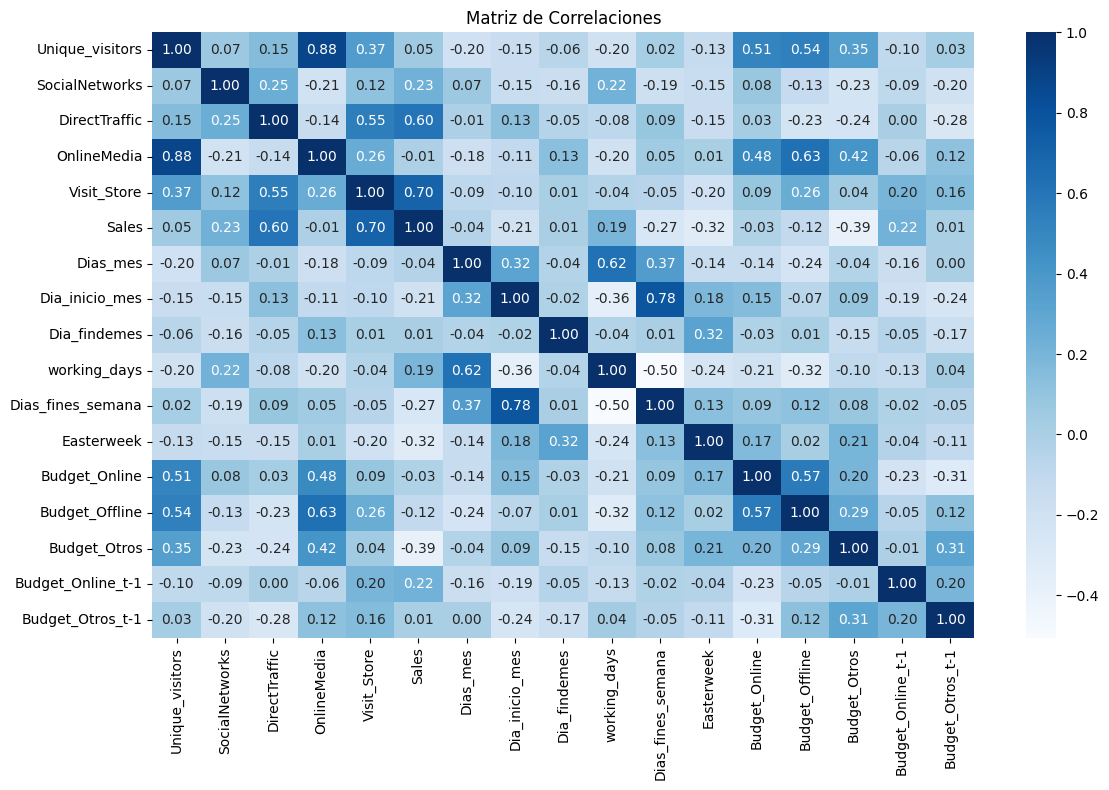

In [17]:
# Gráfico de correlación entre variables.
cols_to_drop = ["INTERNET", "PlataformasVideo", "RADIO", "PRENSA",
                "REVISTAS", "EXTERIOR", "CINE", "PRODUCCION", "VARIOS"]
# Columnas originales de inversión que ahora agrupamos.
correlation_matrix = df.drop(columns=cols_to_drop).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matriz de Correlaciones")
plt.tight_layout()
plt.show()

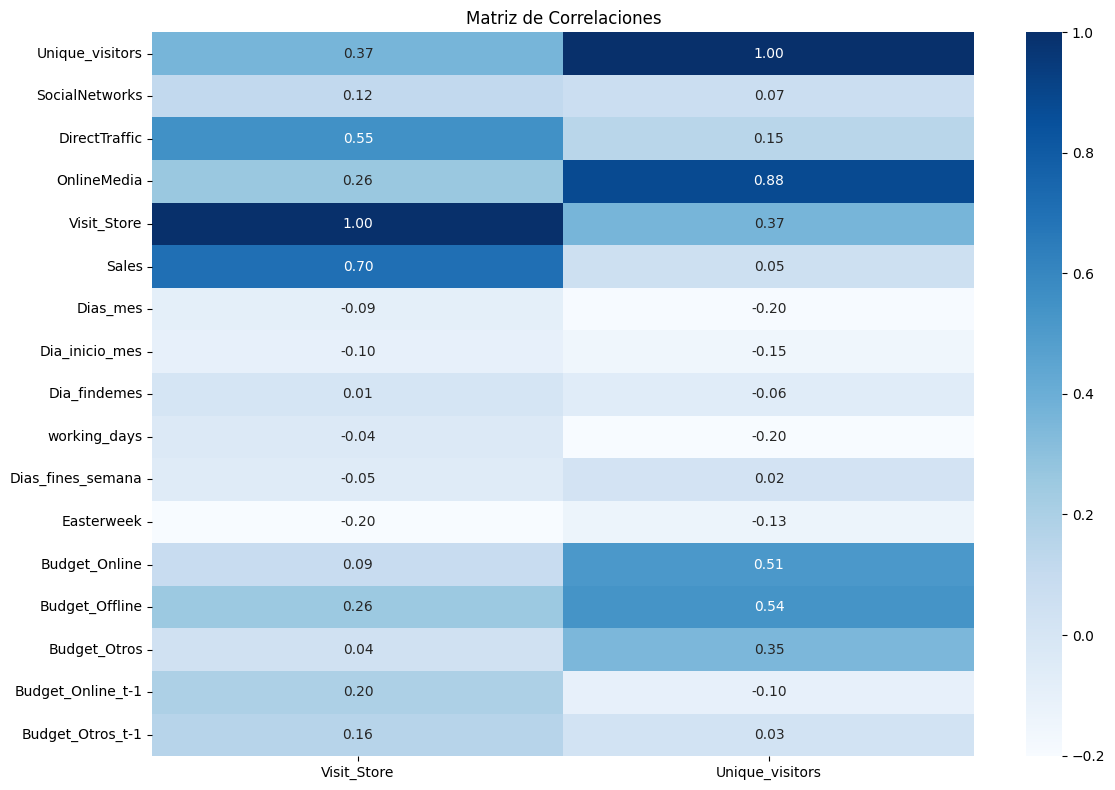

In [18]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['Visit_Store','Unique_visitors']], annot=True, cmap="Blues", fmt=".2f")
plt.title("Matriz de Correlaciones")
plt.tight_layout()
plt.show()

### **Inputs clave del modelo: Evolución y patrones.**

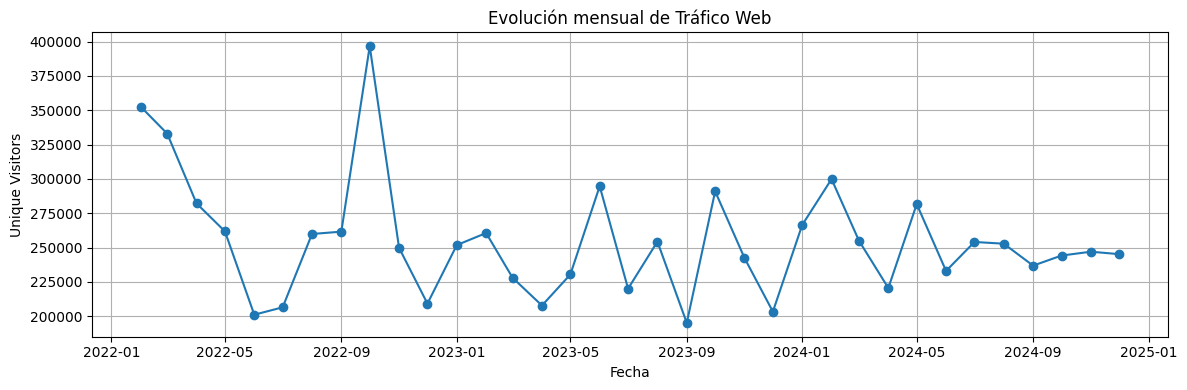

In [19]:
# Gráfico de Unique Visitors por mes.
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Unique_visitors'], marker='o')
plt.title(f"Evolución mensual de Tráfico Web")
plt.xlabel("Fecha")
plt.ylabel('Unique Visitors')
plt.grid(True)
plt.tight_layout()
plt.show()

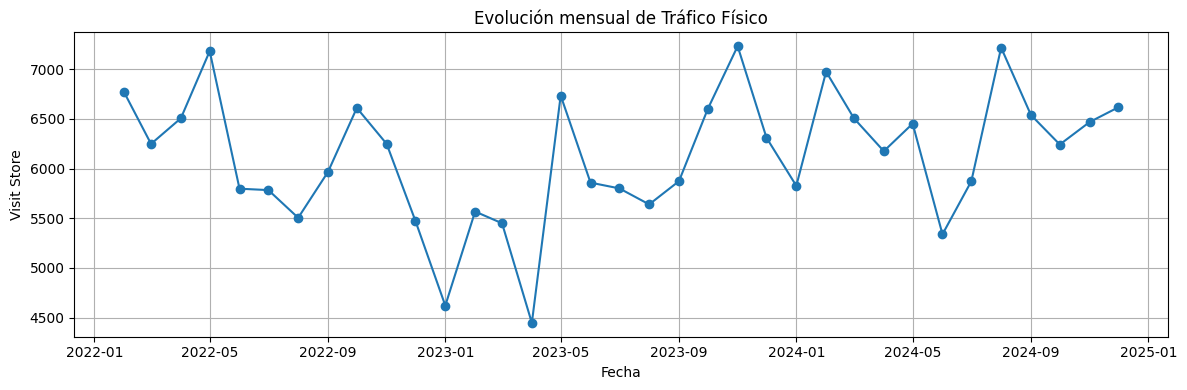

In [20]:
# Gráfico de Visit Store por mes.
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Visit_Store'], marker='o')
plt.title(f"Evolución mensual de Tráfico Físico")
plt.xlabel("Fecha")
plt.ylabel('Visit Store')
plt.grid(True)
plt.tight_layout()
plt.show()

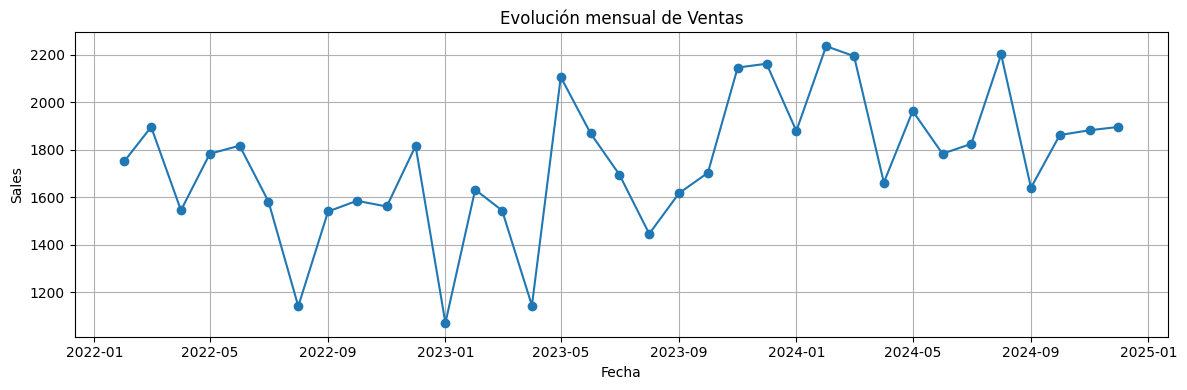

In [21]:
# Gráfico de Sales por mes.
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Sales'], marker='o')
plt.title(f"Evolución mensual de Ventas")
plt.xlabel("Fecha")
plt.ylabel('Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

### **Creación de Variables Exógenas.**
Con el objetivo de capturar factores externos que pueden influir en el comportamiento del consumidor y, por tanto, en el tráfico físico a tienda, se han creado variables exógenas basadas en la estacionalidad, el calendario laboral y los principales eventos comerciales del año. Estas variables nuevas permiten al modelo incorporar efectos de campañas puntuales o periodos vacacionales que impactan directamente en las visitas o ventas, y complementan a las variables continuas como `Working days`, `Dias fines semana` y `Easter Week`, que recogen el calendario operativo del negocio. La incorporación de estas exógenas mejora la capacidad explicativa del modelo y lo dota de mayor robustez frente a patrones recurrentes del entorno.

In [22]:
df["Navidad"] = (df.index.month == 12).astype(int)
df["BlackFriday"] = (df.index.month == 11).astype(int)
df["Trimestre"] = df.index.month // 4 + 1  # Trimestre del año (1 a 4).
df["Vuelta_cole"] = (df.index.month == 9).astype(int)
df["Rebajas"] = df.index.month.isin([1, 7]).astype(int)  # Opcional: Rebajas de enero y julio.
df["Mes"] = df.index.month  # Mes del año (1 a 12).
df["Año"] = df.index.year  # Año (2020, 2021, ...).
df["Fin_de_mes"] = df["Mes"].isin([3, 6, 9, 12]).astype(int) # Fin de mes: más gasto por cierre de ciclo.

In [23]:
df[["Navidad", "BlackFriday", "Trimestre", "Vuelta_cole", "Rebajas", "Mes", "Fin_de_mes"]].head()

,Navidad,BlackFriday,Trimestre,Vuelta_cole,Rebajas,Mes,Fin_de_mes
ID_Date,,,,,,,
2022-02-01,0,0,1,0,0,2,0
2022-03-01,0,0,1,0,0,3,1
2022-04-01,0,0,2,0,0,4,0
2022-05-01,0,0,2,0,0,5,0
2022-06-01,0,0,2,0,0,6,1


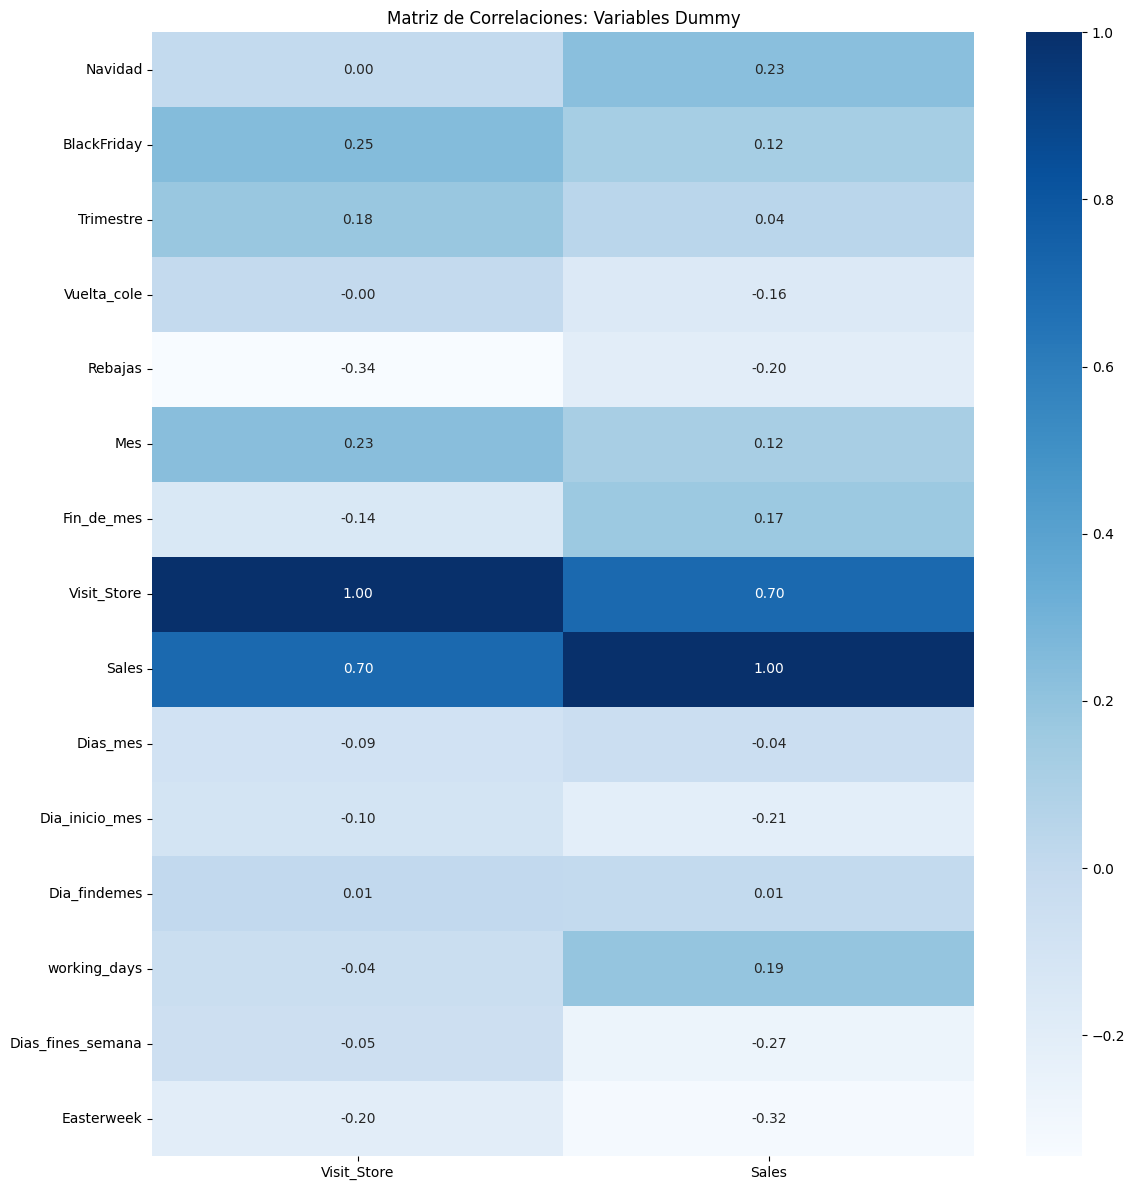

In [24]:
time_cols = ["Navidad", "BlackFriday", "Trimestre", "Vuelta_cole", "Rebajas", "Mes", "Fin_de_mes",
             "Visit_Store", "Sales", "Dias_mes", "Dia_inicio_mes", "Dia_findemes",
             "working_days", "Dias_fines_semana", "Easterweek"]
corr = df[time_cols].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr[['Visit_Store', 'Sales']], annot=True, cmap="Blues", fmt=".2f")
plt.title("Matriz de Correlaciones: Variables Dummy")
plt.tight_layout()
plt.show()

## **Modelado Exploratorio en Dos Etapas**

### **Modelo de Predicción de Visitas a Tienda (`Visit_Store`)**
Esta etapa corresponde al primer paso del **Objetivo 2**, en el que se construye un modelo de atribución publicitaria enfocado en explicar el comportamiento mensual del tráfico físico a tienda. El objetivo es estimar el volumen de visitas (`Visit_Store`) en función de la inversión en medios y de otras variables relevantes, como el tráfico web y factores temporales.

Este modelo sigue una lógica basada en la teoría del embudo de conversión en retail:

$$
\text{Inversión Publicitaria + Tráfico Web + Calendario → Visitas Físicas a Tienda}
$$

La variable dependiente (`Visit_Store`) se modeliza a partir de:

- **Inversión publicitaria agregada**, clasificada en:
  - `Budget_Online`: publicidad digital
  - `Budget_Offline`: medios tradicionales
  - `Budget_Otros`: producción y gastos menores
- **Tráfico Web (`Unique_visitors`)**: considerado aquí como variable real, ya que aún estamos en fase de entrenamiento (en simulación futura se sustituirá por forecast).
- **Factores temporales**.

Este modelo constituye la primera capa de la cadena causal completa que se desarrollará posteriormente, donde se estimarán también las ventas (`Sales`) a partir de las visitas físicas.

- Se aplicará una **regresión múltiple lineal**, inicialmente sin regularización, para interpretar fácilmente los coeficientes y evaluar su signo e impacto.
- La **métrica principal de evaluación** será el coeficiente de determinación **R²**, que mide la proporción de varianza explicada por el modelo.
- No se aplicará delay (*t-1*) en esta etapa, ya que el efecto de la inversión y del tráfico web sobre el tráfico en tienda se considera inmediato dentro del mismo mes.
- El análisis se basa exclusivamente en los **36 periodos históricos disponibles** (datos mensuales), por lo que se evita un uso excesivo de transformaciones o retardo.

> Esta etapa se centra en el modelado explicativo del comportamiento observado. La lógica de optimización y simulación de escenarios publicitarios se aplicará en fases posteriores del trabajo.

In [25]:
# Filtrar columnas relevantes.
features_visits = [
    "Budget_Online_t-1", "Budget_Offline", "Budget_Otros_t-1",
    "Unique_visitors", "DirectTraffic",
    "BlackFriday", "Trimestre", "Dia_findemes",
]

# Separar variables predictoras (X) y objetivo (y).
X_train = df[features_visits]
y_train = df["Visit_Store"]

# Mostrar dimensiones del conjunto final de entrenamiento.
X_train.shape, y_train.shape

((35, 8), (35,))

In [26]:
model_visits = LinearRegression(fit_intercept=True)
model_visits.fit(X_train, y_train)

LinearRegression()

In [27]:
# Realizar predicciones sobre el conjunto de entrenamiento.
y_pred = model_visits.predict(X_train)

# Calcular métricas de evaluación.
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")

Mean Squared Error (MSE): 159172.7077
Coeficiente de Determinación (R²): 0.6205


In [28]:
visits_coef = pd.DataFrame({
    "Variable": X_train.columns,
    "Coeficiente": model_visits.coef_
})
visits_coef

,Variable,Coeficiente
0,Budget_Online_t-1,0.000420
1,Budget_Offline,0.004542
2,Budget_Otros_t-1,0.011545
3,Unique_visitors,0.002402
4,DirectTraffic,0.016919
5,BlackFriday,58.888993
6,Trimestre,159.321198
7,Dia_findemes,11.703456


**Interpretación de los coeficientes del modelo de predicción de ventas.**

Los resultados obtenidos en esta versión del modelo reflejan una estructura sólida y coherente desde el punto de vista del comportamiento comercial y la atribución publicitaria. Las **variables de inversión muestran un impacto positivo sobre las ventas**, diferenciando claramente entre canales y tiempos de respuesta: mientras que **la inversión en medios tradicionales parece tener un efecto más inmediato, las partidas digitales y de producción requieren un mes de retardo para manifestar su influencia en las ventas**, lo que resulta lógico dada la planificación y ejecución de campañas en estos canales.

En cuanto al tráfico digital, tanto el volumen total de visitantes (`Unique Visitors`) como el tráfico directo (`Direct Traffic`) se comportan como **impulsores positivos del comportamiento de compra**. Esto refuerza la importancia del ecosistema digital no solo como canal de atracción, sino también como facilitador de la conversión final, especialmente cuando el visitante ya está familiarizado con la marca o el producto.

Desde el punto de vista estacional, la variable que recoge el efecto del trimestre presenta un impacto relevante, lo que indica que **determinadas etapas del año (como el último trimestre) concentran un mayor volumen de ventas**, probablemente debido a campañas clave o a picos naturales de consumo. Asimismo, el evento de `Black Friday` actúa como catalizador comercial, generando un **efecto positivo** bien definido sobre las ventas. Finalmente, la incorporación del indicador `Dia Fin De Mes` sugiere que los días finales del mes pueden ejercer una influencia adicional en la activación del consumo, posiblemente relacionada con la disponibilidad reciente de ingresos o con el cierre natural del ciclo mensual de gasto.

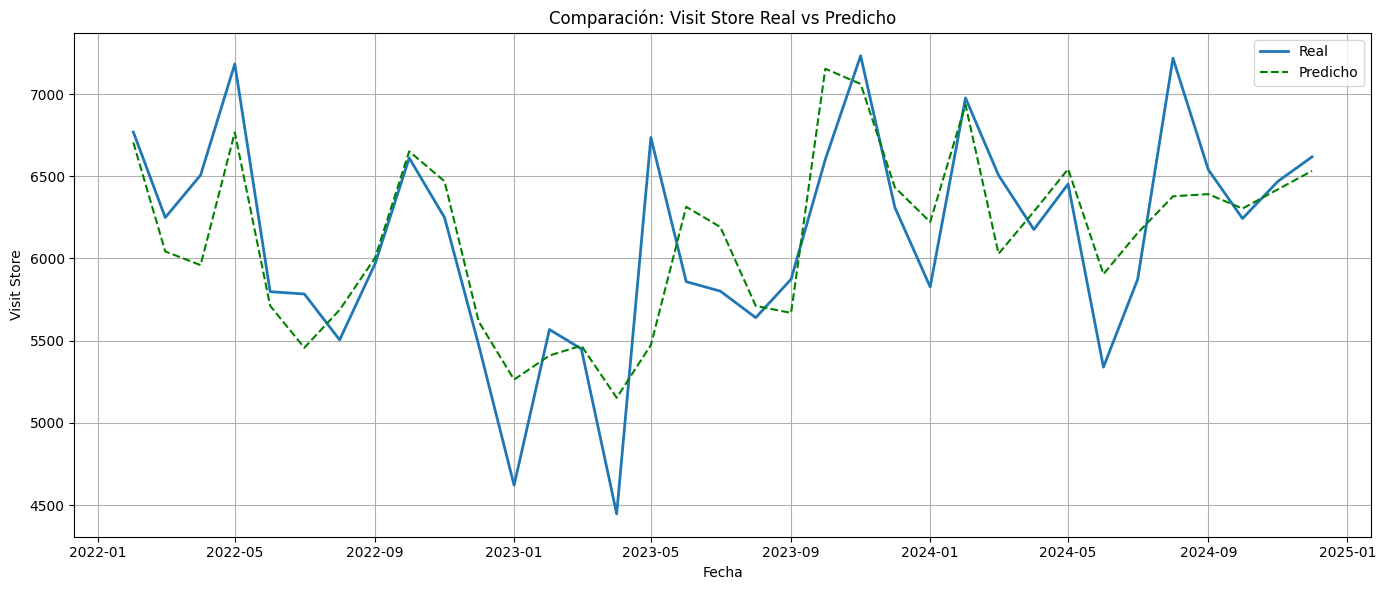

In [29]:
# Gráfico de comparación entre predicciones y valores reales.
df_pred_vs_real = pd.DataFrame({
    "ID_Date": df.index,
    "Visit_Store_REAL": y_train.values,
    "Visit_Store_PRED": y_pred
})
df_pred_vs_real.set_index("ID_Date", inplace=True)


plt.figure(figsize=(14, 6))
plt.plot(df_pred_vs_real.index, df_pred_vs_real["Visit_Store_REAL"], label="Real", linewidth=2)
plt.plot(df_pred_vs_real.index, df_pred_vs_real["Visit_Store_PRED"], label="Predicho", linestyle='--', color='green')
plt.title("Comparación: Visit Store Real vs Predicho")
plt.xlabel("Fecha")
plt.ylabel("Visit Store")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **Modelo de Predicción de Ventas.**
Esta etapa corresponde al segundo paso del **Objetivo 2**, y se enfoca en modelar la conversión de visitas físicas en tienda a ventas mensuales. El objetivo es estimar el volumen de ventas (`Sales`) a partir del tráfico físico (`Visit Store`) previamente modelado, incorporando también factores exógenos de tipo estacional y promocional que afectan directamente a la decisión de compra.

Este modelo sigue la lógica de continuidad dentro del embudo de conversión en retail:

$$
\text{Visitas Físicas a Tienda + Factores Comerciales → Ventas}
$$

La variable dependiente (`Sales`) se modeliza a partir de:

- **Tráfico físico (`Visit Store`)**: representa la base del modelo y conecta directamente con la etapa anterior. Esta variable actúa como driver principal del comportamiento de compra.
- **Factores comerciales estacionales.**

Este modelo constituye la segunda capa del pipeline de atribución, y se utilizará tanto para análisis explicativo como para simulaciones futuras de escenarios de inversión, una vez pronosticado el tráfico (`Visit Store`) con datos proyectados.

- Se aplica una **regresión múltiple lineal**, en coherencia con la etapa anterior, para mantener la interpretabilidad y evaluar la magnitud e impacto de cada variable.
- La **métrica principal de evaluación** sigue siendo el coeficiente de determinación **R²**, que refleja la proporción de varianza explicada sobre el total observado.
- No se incluyen variables relacionadas con el tráfico web ni con la inversión en medios, ya que su efecto ya está contenido dentro de `Visit Store`.

> Esta etapa cierra la cadena causal planteada, permitiendo simular el impacto que una determinada combinación de inversión publicitaria y tráfico digital puede tener sobre las ventas, mediante la estimación encadenada de visitas y compras.

In [30]:
# Filtrar columnas relevantes.
features_sales = ['Visit_Store', 'Navidad', 'Rebajas', 'Fin_de_mes',
                'Easterweek', 'Dias_fines_semana']

# Separar variables predictoras (X) y objetivo (y).
X_train = df[features_sales]
y_train = df['Sales']

# Mostrar dimensiones del conjunto final de entrenamiento.
X_train.shape, y_train.shape

((35, 6), (35,))

In [31]:
model_sales = LinearRegression()
model_sales.fit(X_train, y_train)

LinearRegression()

In [32]:
# Realizar predicciones sobre el conjunto de entrenamiento.
y_pred = model_sales.predict(X_train)

# Calcular métricas de evaluación.
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Coeficiente de Determinación (R²): {r2:.2f}")

Mean Squared Error (MSE): 26141.43
Coeficiente de Determinación (R²): 0.68


In [33]:
sales_coef = pd.DataFrame({
    "Variable": X_train.columns,
    "Coeficiente": model_sales.coef_
})
sales_coef

,Variable,Coeficiente
0,Visit_Store,0.356875
1,Navidad,187.818154
2,Rebajas,246.731620
3,Fin_de_mes,107.271389
4,Easterweek,-24.923637
5,Dias_fines_semana,-109.371711


**Interpretación del modelo de predicción de ventas.**

El modelo final de predicción de ventas presenta una estructura clara y coherente con el comportamiento esperado del consumidor en un entorno comercial. La variable principal, `Visit Store`, actúa como el motor del modelo, reflejando el vínculo directo entre el volumen de tráfico físico a tienda y las compras realizadas. Su presencia asegura que el modelo esté alineado con la lógica de conversión natural del funnel de ventas.

Las variables estacionales aportan matices relevantes al comportamiento mensual. `Navidad` y `Rebajas` destacan por su **impacto positivo**, lo que confirma que estos momentos del calendario comercial actúan como catalizadores del consumo. Estas variables capturan los efectos promocionales y culturales que impulsan a los clientes a comprar en periodos específicos, independientemente del volumen de tráfico.

El indicador `Fin De Mes` también presenta un efecto positivo sobre las ventas, lo cual es coherente con la tendencia del consumidor a realizar **más compras en los últimos días del mes, posiblemente asociado a la percepción de ingresos disponibles o al cierre de ciclos financieros personales.**

Por el contrario, variables como `Easter Week` y `Dias Fines Semana` reflejan efectos moderadores. Ambas se relacionan con momentos en los que la **actividad comercial puede disminuir**, ya sea por el desplazamiento durante periodos vacacionales o por cambios en los hábitos de consumo durante fines de semana. Su inclusión en el modelo permite ajustar las predicciones a patrones de comportamiento menos favorables.

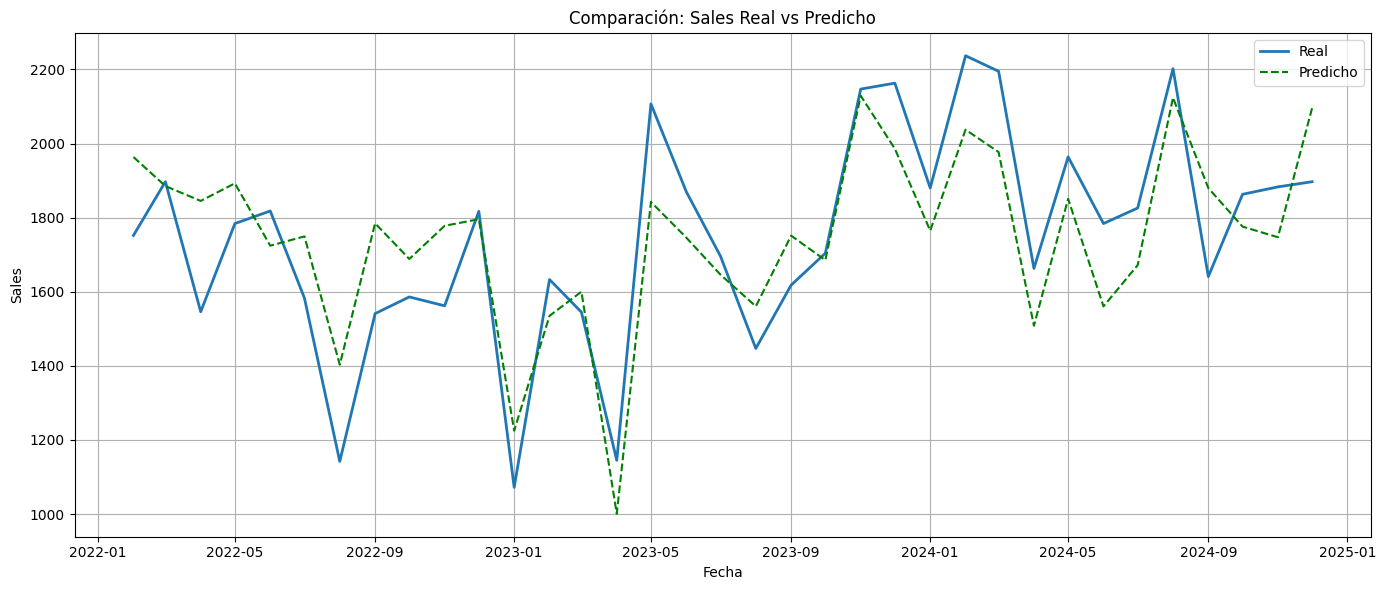

In [34]:
# Gráfico de comparación entre predicciones y valores reales.
df_sales_comparacion = pd.DataFrame({
    "ID_Date": df.index,
    "Sales_REAL": y_train.values,
    "Sales_PRED": y_pred
})
df_sales_comparacion.set_index("ID_Date", inplace=True)

plt.figure(figsize=(14, 6))
plt.plot(df_sales_comparacion.index, df_sales_comparacion["Sales_REAL"], label="Real", linewidth=2)
plt.plot(df_sales_comparacion.index, df_sales_comparacion["Sales_PRED"], label="Predicho", linestyle='--', color='green')
plt.title("Comparación: Sales Real vs Predicho")
plt.xlabel("Fecha")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Simulación de escenarios futuros.**
Con los modelos predictivos ya entrenados para estimar el tráfico físico a tienda (`Visit Store`) y las ventas mensuales (`Sales`), esta etapa final se centra en la simulación de escenarios futuros. El objetivo es evaluar cómo distintas estrategias de inversión publicitaria pueden impactar en el rendimiento comercial de los próximos meses.

Esta simulación parte de una proyección temporal de seis meses, para la cual se utilizan valores futuros de tráfico web (`Unique visitors`) previamente estimados mediante el modelo SARIMA, junto con combinaciones hipotéticas de inversión en medios y eventos comerciales relevantes (como campañas estacionales o número de días hábiles).

La metodología consiste en aplicar los modelos de regresión construidos anteriormente sobre este nuevo dataset simulado, permitiendo calcular el volumen esperado de visitas físicas y ventas bajo distintos supuestos. Esto facilita un análisis comparativo de escenarios (por ejemplo, aumento de inversión digital, reducción de medios tradicionales, o campañas intensivas en fechas clave) y ayuda a identificar combinaciones óptimas de inversión y timing para maximizar resultados.

> Este ejercicio no solo valida el pipeline construido, sino que también ofrece una herramienta estratégica para la toma de decisiones basada en datos y simulación prospectiva.

### **Forecast de Unique Visitors con SARIMA.**
Para llevar a cabo la simulación de escenarios futuros en el modelo de atribución publicitaria, es necesario disponer de una estimación fiable del volumen de tráfico web mensual. Con este propósito, se ha implementado un **modelo SARIMA** (Seasonal AutoRegressive Integrated Moving Average) entrenado sobre la serie histórica de visitantes únicos a la web (`Unique_visitors`).

Este modelo ha sido previamente optimizado mediante **selección automática de hiperparámetros**, y ha demostrado ser adecuado para capturar tanto la tendencia como la estacionalidad presentes en los datos. A partir del ajuste completo del modelo sobre el histórico disponible, se ha generado una **proyección mensual a 24 meses vista**, comenzando desde el mes inmediatamente posterior al último dato observado.

El resultado del forecast constituye la base de entrada del DataFrame `df_futuro`, sobre el cual se integrarán variables exógenas proyectadas y escenarios de inversión publicitaria. Esta estimación anticipada del tráfico web permitirá evaluar de forma prospectiva el efecto de distintas combinaciones de inversión y calendario sobre el comportamiento físico y comercial de la compañía.

In [35]:
df.tail(2)

,Unique_visitors,SocialNetworks,DirectTraffic,OnlineMedia,Visit_Store,Sales,Dias_mes,Dia_inicio_mes,Dia_findemes,working_days,Dias_fines_semana,Easterweek,CINE,EXTERIOR,INTERNET,PRENSA,PRODUCCION,RADIO,REVISTAS,PlataformasVideo,VARIOS,Budget_Online,Budget_Offline,Budget_Otros,Budget_Online_t-1,Budget_Otros_t-1,Navidad,BlackFriday,Trimestre,Vuelta_cole,Rebajas,Mes,Año,Fin_de_mes
ID_Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-01,247005,1939,105747,19585,6469,1883,30,5,5,21,9,0,40391.0,0.0,99600.0,2334.0,621.0,0.0,7105.0,308556.0,4382.0,408156.0,49830.0,5003.0,521909.0,5897.0,0,1,3,0,0,11,2024,0
2024-12-01,245232,1908,106507,15329,6618,1897,31,7,6,22,9,0,50488.0,0.0,108678.0,2355.0,776.0,0.0,7881.0,383628.0,4199.0,492306.0,60724.0,4975.0,408156.0,5003.0,1,0,4,0,0,12,2024,1


In [36]:
# Entrenamiento del modelo SARIMA.
endog = df["Unique_visitors"]

## Cargar los parámetros del modelo SARIMA desde el archivo JSON.
with open("../model/SARIMA_model.json", "r") as f:
    params = json.load(f)
model = SARIMAX(
    endog,
    order=tuple(params["order"]),
    seasonal_order=tuple(params["seasonal_order"])
)

results = model.fit(disp=False)

In [37]:
# Obtener la última fecha del histórico.
ultima_fecha = df.index.max()

# Generar fechas mensuales a partir del mes siguiente.
fechas_futuras = pd.date_range(start=ultima_fecha + pd.offsets.MonthBegin(1), periods=24, freq="MS")

# Forecast de 24 meses.
forecast = results.forecast(steps=24)

In [38]:
# Crear DataFrame futuro.
df_futuro = pd.DataFrame(index=fechas_futuras)
df_futuro["Unique_visitors"] = forecast

### **Construcción del DataFrame Futuro.**
Una vez obtenido el forecast del tráfico web, se procede a la construcción del DataFrame `df_futuro`, que funcionará como base de simulación para los modelos de predicción de visitas físicas (`Visit Store`) y ventas mensuales (`Sales`). Este DataFrame integra de forma estructurada tanto las proyecciones del modelo SARIMA como el resto de variables exógenas necesarias para alimentar los modelos posteriores.

El proceso contempla la incorporación de dimensiones temporales (como días hábiles, fines de semana y eventos comerciales), así como la simulación de escenarios de inversión publicitaria ajustados según las directrices del caso de uso. Para ello, se aplica un incremento del 15% sobre los valores históricos del presupuesto, replicando la planificación proyectada para el primer semestre.

Adicionalmente, se generan variables derivadas clave como indicadores de fin de mes, proporción directa entre tráfico web e inversión o codificaciones categóricas del calendario. Todo ello con el objetivo de dotar al modelo de simulación de un entorno realista, estructurado y flexible, capaz de reflejar múltiples combinaciones de comportamiento comercial futuro.

In [39]:
df_futuro.head()

,Unique_visitors
2025-01-01,285401.594248
2025-02-01,367389.143520
2025-03-01,336943.700332
2025-04-01,308452.435842
2025-05-01,335169.275836


In [40]:
df_futuro.shape # 24 meses -> 2 años.

(24, 1)

#### **Creación del Tráfico Directo.**
Para el conjunto de variables necesarias en la simulación del volumen de visitas físicas (`Visit Store`), es necesario proyectar también el comportamiento futuro de `Direct Traffic`, variable que representa el tráfico directo hacia la web. Inicialmente, se valoró la posibilidad de aplicar un modelo SARIMA sobre esta variable, siguiendo el mismo enfoque empleado en la predicción de `Unique visitors`.

Sin embargo, tras realizar pruebas preliminares, se observó que el modelo presentaba una precisión muy limitada, con métricas de ajuste bajas y una incapacidad clara para capturar patrones consistentes en la serie. Esto puede deberse a la elevada volatilidad de este tipo de tráfico, influenciado por factores externos difíciles de modelar, como acciones orgánicas, fidelización o recordación de marca.

Ante esta situación, se optó por una estrategia alternativa más robusta y transparente: **calcular la media histórica mensual de `Direct Traffic`**, agrupando por mes del año. Esta técnica permite preservar los patrones estacionales aproximados y reduce el riesgo de sobreajuste o predicciones inestables.

En la práctica, para cada mes futuro de la simulación (por ejemplo, enero de 2025), se asigna el valor promedio de `Direct Traffic` observado en todos los meses de enero del histórico disponible. Este enfoque garantiza coherencia estacional, simplicidad interpretativa y continuidad metodológica dentro del modelo de simulación.

In [41]:
# 1. Promedio mensual para 2025 con 2022–2024.
media_2025 = df.loc["2022":"2024"].groupby(df.index.month)["DirectTraffic"].mean()
df_futuro.loc[df_futuro.index.year == 2025, "DirectTraffic"] = df_futuro.loc[
    df_futuro.index.year == 2025
].index.month.map(media_2025)

# 2. Promedio mensual para 2026 con 2022–2025.
# Unir histórico con predicción 2025 para construir promedio extendido.
direct_all = pd.concat([df[["DirectTraffic"]], df_futuro.loc[df_futuro.index.year == 2025, ["DirectTraffic"]]])

media_2026 = direct_all.groupby(direct_all.index.month)["DirectTraffic"].mean()
df_futuro.loc[df_futuro.index.year == 2026, "DirectTraffic"] = df_futuro.loc[
    df_futuro.index.year == 2026
].index.month.map(media_2026)

#### **Inclusión de variables exógenas proyectadas.**
Con el objetivo de enriquecer el DataFrame de simulación, se incorporan variables exógenas de naturaleza temporal previamente utilizadas en el modelado, como el número de días hábiles, fines de semana y eventos especiales. Estas variables permiten capturar patrones estacionales y comportamientos recurrentes del consumidor, asegurando mayor robustez y realismo en las predicciones futuras de visitas y ventas.

In [42]:
exog = []
for i in features_sales + features_visits:
    if (i not in ['Visit_Store', 'DirectTraffic', 'Unique_visitors']) and not i.startswith('Budget_'):
        exog.append(i)
print('Variables exógenas:', ', '.join(exog))

Variables exógenas: Navidad, Rebajas, Fin_de_mes, Easterweek, Dias_fines_semana, BlackFriday, Trimestre, Dia_findemes


**Cálculo de variables exógenas simples vs. iterativas.** En la construcción del DataFrame `df_futuro`, se incorporan dos tipos de variables exógenas de naturaleza temporal:

1. **Variables exógenas directas (calculadas a partir del índice):** Estas variables se derivan **directamente del índice de fechas mensual**, sin necesidad de acumulación ni lógica secuencial:
    - **`Navidad`**: indica si el mes corresponde a diciembre.
    - **`Rebajas`**: señala los meses de campañas de rebajas (enero y julio).
    - **`Mes` / `Año`**: extraídos directamente del índice.
    - **`Fin_de_mes`**: marca los meses de cierre de trimestre (marzo, junio, septiembre y diciembre), donde se espera mayor actividad promocional o gasto.
    - **`BlackFriday`**: marca noviembre como mes clave de descuentos.
    - **`Trimestre`**: calcula el trimestre del año en curso.
    - **`Easterweek`**: asigna un valor al mes de abril, correspondiente con la Semana Santa.

2. **Variables exógenas iterativas (calculadas acumulativamente):** Otras variables requieren **una lógica de cálculo basada en la evolución del calendario**, ya que dependen del día de la semana en que empieza o termina cada mes:
    - **`Dia inicio mes`**: día de la semana en que comienza el mes.
    - **`Dia fin de mes`**: día de la semana en que termina el mes.
    - **`Dias fines semana`**: número de sábados y domingos en el mes.
    - **`Working days`**: número de días laborables estimados por exclusión de fines de semana.

Estas variables no pueden derivarse directamente del índice y requieren mantener el estado del calendario mes a mes, para preservar su coherencia interna con el histórico.?

In [43]:
df_futuro["Navidad"] = (df_futuro.index.month == 12).astype(int)
df_futuro["Rebajas"] = df_futuro.index.month.isin([1, 7]).astype(int)  # Rebajas de enero y julio.
df_futuro["Mes"] = df_futuro.index.month  # Mes del año (1 a 12).
df_futuro['Año'] = df_futuro.index.year
df_futuro["Fin_de_mes"] = df_futuro["Mes"].isin([3, 6, 9, 12]).astype(int) # Fin de mes: más gasto por cierre de ciclo.
df_futuro["BlackFriday"] = (df_futuro.index.month == 11).astype(int)
df_futuro["Trimestre"] = df_futuro.index.month // 4 + 1  # Trimestre del año (1 a 4).
df_futuro["Easterweek"] = (df_futuro.index.month == 4).astype(int) # Easterweek: Semana Santa.

In [44]:
# Función para contar sábados y domingos en un mes.
def contar_fines_de_semana(dia_inicio_mes, dias_mes):
    start_weekday = (dia_inicio_mes - 1) % 7  # lunes=1..domingo=7 → 0..6
    dias_finde = 0
    for i in range(dias_mes):
        if (start_weekday + i) % 7 in [5, 6]:  # 5=sábado, 6=domingo
            dias_finde += 1
    return dias_finde

# Obtener valores iniciales desde la última fila de df.
ultima_fecha = df.index.max()
dia_inicio_actual = int(df.loc[ultima_fecha, 'Dia_inicio_mes'])
dias_actual = int(df.loc[ultima_fecha, 'Dias_mes'])

# Calcular días del mes para el futuro.
df_futuro["Dias_mes"] = df_futuro.index.days_in_month

# Inicializar columnas destino.
df_futuro["Dia_inicio_mes"] = None
df_futuro["Dia_findemes"] = None
df_futuro["Dias_fines_semana"] = None
df_futuro["working_days"] = None
for fecha in df_futuro.index:
    dias_mes = df_futuro.loc[fecha, "Dias_mes"]

    # Día inicio y fin de mes.
    dia_inicio = ((dia_inicio_actual + (dias_actual % 7) - 1) % 7) + 1
    dia_fin = ((dia_inicio + dias_mes - 2) % 7) + 1

    # Fines de semana y laborables.
    dias_finde = contar_fines_de_semana(dia_inicio, dias_mes)
    dias_laborables = dias_mes - dias_finde

    # Guardar resultados.
    df_futuro.at[fecha, "Dia_inicio_mes"] = dia_inicio
    df_futuro.at[fecha, "Dia_findemes"] = dia_fin
    df_futuro.at[fecha, "Dias_fines_semana"] = dias_finde
    df_futuro.at[fecha, "working_days"] = dias_laborables

    # Actualizar para la siguiente iteración.
    dia_inicio_actual = dia_inicio
    dias_actual = dias_mes

# Asegurar tipos correctos
df_futuro[["Dia_inicio_mes", "Dia_findemes", "Dias_fines_semana", "working_days"]] = \
    df_futuro[["Dia_inicio_mes", "Dia_findemes", "Dias_fines_semana", "working_days"]].astype(int)

In [45]:
df_futuro.head()

,Unique_visitors,DirectTraffic,Navidad,Rebajas,Mes,Año,Fin_de_mes,BlackFriday,Trimestre,Easterweek,Dias_mes,Dia_inicio_mes,Dia_findemes,Dias_fines_semana,working_days
2025-01-01,285401.594248,96644.000000,0,1,1,2025,0,0,1,0,31,3,5,8,23
2025-02-01,367389.143520,92794.666667,0,0,2,2025,0,0,1,0,28,6,5,8,20
2025-03-01,336943.700332,82812.000000,0,0,3,2025,1,0,1,0,31,6,1,10,21
2025-04-01,308452.435842,72764.666667,0,0,4,2025,0,0,2,1,30,2,3,8,22
2025-05-01,335169.275836,72812.333333,0,0,5,2025,0,0,2,0,31,4,6,9,22


### **Simulación del presupuesto base de escenario ajustado según documento de referencia.**
Con el objetivo de analizar el impacto de la inversión publicitaria en las visitas físicas y las ventas, se construye un escenario base de simulación a partir del presupuesto del año 2024. Esta proyección parte de la premisa de que los presupuestos mensuales se ajustarán según una política establecida, que refleja los objetivos de crecimiento de la compañía y permite explorar diferentes combinaciones de inversión futura.

El presupuesto base se ajusta de la siguiente forma:
- **Primer semestre**: se aplica un incremento del 15% respecto a los valores observados en 2024.
- **Segundo semestre**: se incrementa en un 21%.
- **Año siguiente completo (2026)**: se considera un incremento del 25% sobre el total anual base.

Esta estrategia define una **línea de partida estructurada** desde la cual el modelo puede estimar el impacto de cada canal de inversión sobre el tráfico web, las visitas físicas a tienda y, en última instancia, sobre las ventas. A partir de este escenario base, es posible construir simulaciones alternativas modificando la asignación por canal, los momentos del gasto o el volumen total.

El modelo asignará pesos a cada canal (online, offline, otros) mediante una regresión múltiple ajustada, empleando técnicas como Ridge o modelos bayesianos para manejar la multicolinealidad. Este enfoque no solo permite estimar resultados bajo condiciones realistas, sino también ofrecer un marco flexible para explorar **qué ocurriría si se redistribuye la inversión entre canales o se intensifica el gasto en determinados periodos clave**.

En conjunto, esta simulación no representa una predicción cerrada, sino una **herramienta de análisis estratégico** para la toma de decisiones basada en datos.

In [46]:
# Calcular promedio mensual de cada tipo de presupuesto en 2024.
base_online = df.loc["2024", "Budget_Online"].mean()
base_offline = df.loc["2024", "Budget_Offline"].mean()
base_otros = df.loc["2024", "Budget_Otros"].mean()

# Función de incremento por periodo.s
def get_incremento(fecha):
    if fecha.year == 2025 and fecha.month <= 6:
        return 1.15
    elif fecha.year == 2025:
        return 1.21
    elif fecha.year == 2026:
        return 1.25
    else:
        return 1.0

# Aplicación de la función de incremento a los presupuestos futuros.
df_futuro["Budget_Online"] = df_futuro.index.map(lambda d: base_online * get_incremento(d))
df_futuro["Budget_Offline"] = df_futuro.index.map(lambda d: base_offline * get_incremento(d))
df_futuro["Budget_Otros"] = df_futuro.index.map(lambda d: base_otros * get_incremento(d))

**Variables desfasadas `t-1` en la inversión publicitaria.**

Con el fin de modelar correctamente la relación temporal entre la inversión y su impacto en el tráfico físico (`Visit Store`), se incorporan al DataFrame `df_futuro` las versiones desfasadas de las variables de inversión: `Budget Online t-1` y `Budget Otros t-1`.

Estas variables representan el valor de inversión en cada canal **en el mes inmediatamente anterior**, bajo el supuesto de que los efectos de la comunicación publicitaria no se manifiestan de forma instantánea, sino con cierto retardo.

Para construir estas variables, se aplica un **desplazamiento de una fila hacia abajo (lag 1)** sobre las columnas correspondientes a la inversión proyectada. Como consecuencia de este desfase, la primera fila del periodo simulado (enero de 2025) queda inicialmente vacía al no tener un mes anterior en el `df_futuro`. Para resolver esta discontinuidad, se **rellena manualmente con el valor correspondiente al mes de diciembre de 2024**, último mes disponible del histórico real.

Esta estrategia permite mantener la continuidad lógica de la serie y asegurar que el modelo disponga de un input válido desde el primer mes de simulación. Además, respeta la lógica temporal del modelo, en la que los efectos de una inversión se atribuyen a su impacto diferido en el comportamiento del consumidor.

In [47]:
last_online = df.loc["2024-12-01", "Budget_Online"]
last_otros = df.loc["2024-12-01", "Budget_Otros"]

# Crear columnas en df_futuro.
df_futuro["Budget_Online_t-1"] = None
df_futuro["Budget_Otros_t-1"] = None

# Rellenar la primera fila de df_futuro (enero 2025) con el último valor de 2024.
df_futuro.iloc[0, df_futuro.columns.get_loc("Budget_Online_t-1")] = last_online
df_futuro.iloc[0, df_futuro.columns.get_loc("Budget_Otros_t-1")] = last_otros

# Rellenar el resto usando el presupuesto simulado del mes anterior.
df_futuro.loc[df_futuro.index[1:], "Budget_Online_t-1"] = df_futuro["Budget_Online"].iloc[:-1].values
df_futuro.loc[df_futuro.index[1:], "Budget_Otros_t-1"] = df_futuro["Budget_Otros"].iloc[:-1].values

In [48]:
df_futuro.head()

,Unique_visitors,DirectTraffic,Navidad,Rebajas,Mes,Año,Fin_de_mes,BlackFriday,Trimestre,Easterweek,Dias_mes,Dia_inicio_mes,Dia_findemes,Dias_fines_semana,working_days,Budget_Online,Budget_Offline,Budget_Otros,Budget_Online_t-1,Budget_Otros_t-1
2025-01-01,285401.594248,96644.000000,0,1,1,2025,0,0,1,0,31,3,5,8,23,623746.054214,73127.083703,7385.899198,492306.0,4975.0
2025-02-01,367389.143520,92794.666667,0,0,2,2025,0,0,1,0,28,6,5,8,20,623746.054214,73127.083703,7385.899198,623746.054214,7385.899198
2025-03-01,336943.700332,82812.000000,0,0,3,2025,1,0,1,0,31,6,1,10,21,623746.054214,73127.083703,7385.899198,623746.054214,7385.899198
2025-04-01,308452.435842,72764.666667,0,0,4,2025,0,0,2,1,30,2,3,8,22,623746.054214,73127.083703,7385.899198,623746.054214,7385.899198
2025-05-01,335169.275836,72812.333333,0,0,5,2025,0,0,2,0,31,4,6,9,22,623746.054214,73127.083703,7385.899198,623746.054214,7385.899198


### **Aplicación del modelo de predicción de Visit Store.**
Una vez construido el DataFrame `df_futuro` con todas las variables proyectadas necesarias —incluyendo el forecast de tráfico web, las variables exógenas temporales y la simulación del presupuesto publicitario— se procede a aplicar el modelo de predicción de visitas físicas (`Visit Store`).

Este modelo fue previamente entrenado sobre datos históricos mediante una regresión múltiple regularizada, integrando diferentes canales de inversión (`Online`, `Offline`, `Otros`), el tráfico digital (`Unique visitors`) y variables temporales como días laborables, estacionalidad o campañas específicas. La versión final del modelo incorporó técnicas para mitigar la multicolinealidad entre predictores y optimizar la capacidad explicativa sin sobreajuste.

En esta fase, se prepara la matriz `X_futuro_visit` con las mismas variables utilizadas durante el entrenamiento, asegurando la coherencia estructural entre los datasets. A continuación, se aplica el modelo sobre el periodo proyectado para estimar el volumen mensual de visitas físicas a tienda (`Visit_Store_PRED`).

La predicción resultante se visualizará junto a los principales eventos del calendario y tramos de inversión, permitiendo evaluar el comportamiento esperado bajo el escenario base. Este paso constituye el primer eslabón del modelo de atribución completo, que continuará en la siguiente sección con la estimación de las ventas (`Sales`).

In [49]:
print('Columnas Modelo de Predicción de Visitas:', ', '.join(features_visits))

Columnas Modelo de Predicción de Visitas: Budget_Online_t-1, Budget_Offline, Budget_Otros_t-1, Unique_visitors, DirectTraffic, BlackFriday, Trimestre, Dia_findemes


In [50]:
X_futuro_visit = df_futuro[features_visits].copy()

In [51]:
# Aplicación el modelo entrenado.
df_futuro["Visit_Store"] = model_visits.predict(X_futuro_visit)

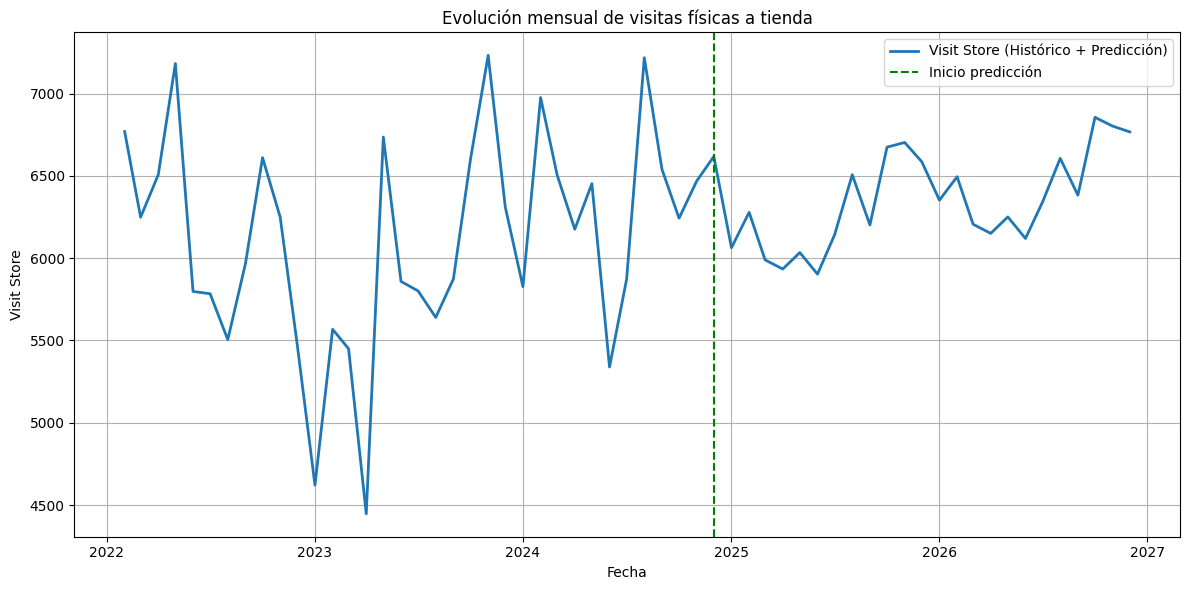

In [52]:
# Visualización de evolución mensual.
df_historico_visitas = df[["Visit_Store"]].copy()
df_futuro_visitas = df_futuro[["Visit_Store"]].copy()
df_total_visitas = pd.concat([df_historico_visitas, df_futuro_visitas])

plt.figure(figsize=(12, 6))
plt.plot(df_total_visitas.index, df_total_visitas["Visit_Store"], label="Visit Store (Histórico + Predicción)", linewidth=2)
plt.axvline(df_historico_visitas.index.max(), color="green", linestyle="--", label="Inicio predicción")
plt.title("Evolución mensual de visitas físicas a tienda")
plt.xlabel("Fecha")
plt.ylabel("Visit Store")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

La predicción mensual del volumen de visitas físicas a tienda (`Visit Store`) mostrada en esta gráfica se ha generado a partir del escenario base de simulación definido en el caso de uso. En dicho escenario, se parte del presupuesto histórico del año 2024, sobre el cual se aplican los siguientes ajustes proyectados:

- **+15%** de incremento en el presupuesto durante los primeros 6 meses del año.
- **+21%** en los siguientes 6 meses.
- **+25%** en el conjunto del año siguiente (2026).

Este enfoque permite estimar **cómo evolucionaría la afluencia** a tienda si se mantuvieran las relaciones históricas entre inversión publicitaria, tráfico web y variables del calendario, **bajo un entorno presupuestario controlado**.

El resultado constituye una **línea base de comparación** frente a la cual se podrán evaluar distintos escenarios alternativos, como cambios en la distribución mensual del gasto, concentración en determinados canales o modificaciones en el mix de inversión. Es, por tanto, una referencia fundamental para la simulación estratégica y la toma de decisiones basada en datos.

### **Aplicación del modelo de predicción de Sales.**
Una vez estimado el volumen de visitas físicas a tienda (`Visit_Store`), se aplica el modelo de predicción de ventas previamente entrenado para proyectar la evolución mensual de `Sales`. Este modelo combina variables clave como la afluencia a tienda, la inversión publicitaria y factores estacionales, permitiendo anticipar el comportamiento comercial bajo el escenario presupuestario simulado. La salida constituye una estimación coherente y cuantificable del impacto previsto en las ventas.

In [53]:
print('Columnas Modelo de Predicción de Ventas:', ', '.join(features_sales))

Columnas Modelo de Predicción de Ventas: Visit_Store, Navidad, Rebajas, Fin_de_mes, Easterweek, Dias_fines_semana


In [54]:
X_futuro_sales = df_futuro[features_sales].copy()

In [55]:
# Aplicación el modelo entrenado.
df_futuro["Sales"] = model_sales.predict(X_futuro_sales)

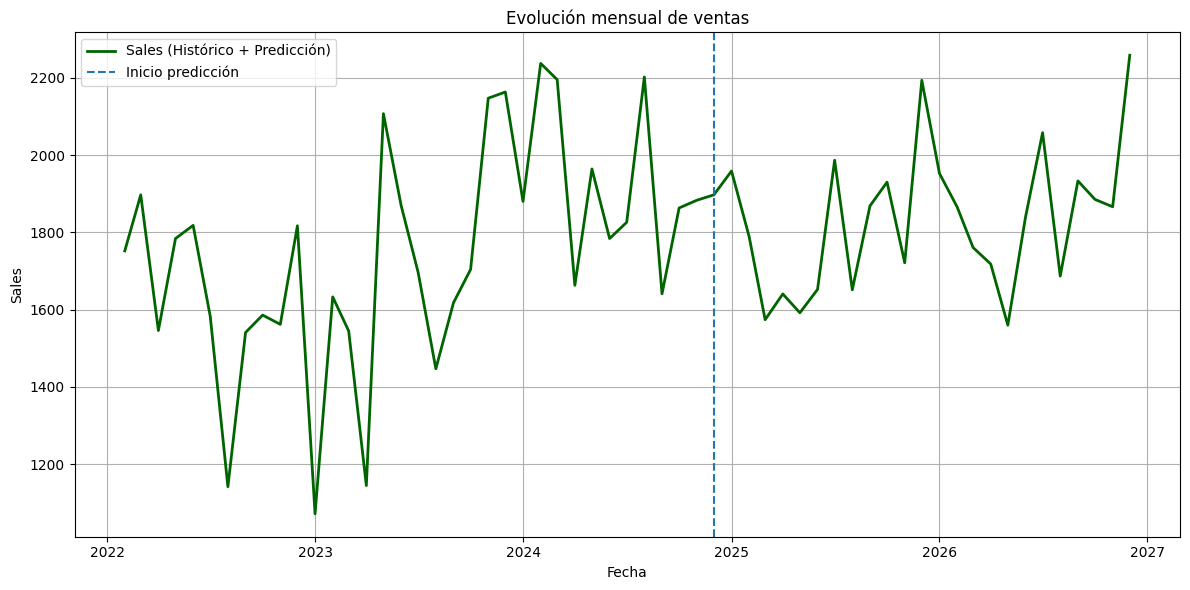

In [56]:
# Visualización de evolución mensual.
df_historico_sales = df[["Sales"]].copy()
df_futuro_sales = df_futuro[["Sales"]].copy()
df_total_sales = pd.concat([df_historico_sales, df_futuro_sales])

plt.figure(figsize=(12, 6))
plt.plot(df_total_sales.index, df_total_sales["Sales"], label="Sales (Histórico + Predicción)", linewidth=2, color="darkgreen")
plt.axvline(df_historico_sales.index.max(), linestyle="--", label="Inicio predicción")
plt.title("Evolución mensual de ventas")
plt.xlabel("Fecha")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

La gráfica muestra la evolución mensual estimada de `Sales`, combinando el histórico real con las predicciones generadas a partir del modelo de regresión ajustado. Esta proyección se construye tomando como insumo la predicción previa de visitas físicas (`Visit Store`) junto con las variables de inversión publicitaria proyectadas y demás factores exógenos relevantes.

El modelo aplicado fue entrenado sobre datos históricos, y permite estimar el impacto conjunto de las visitas a tienda, el mix de inversión y el contexto temporal sobre el comportamiento mensual de las ventas.

El periodo de predicción parte de enero de 2025, y utiliza como escenario base un presupuesto ajustado que contempla:
- **+15% de inversión** en los primeros seis meses,
- **+21%** en los seis siguientes,
- y **+25%** en el año completo 2026 (respecto al presupuesto de referencia de 2024).

Esta estimación refleja el comportamiento esperado bajo condiciones planificadas, sirviendo como punto de partida para explorar escenarios alternativos y optimizar la asignación del presupuesto publicitario con base en la evolución proyectada de la conversión.

### **Comparativa de escenarios de inversión y eficiencia.**
Con el objetivo de analizar cómo distintas combinaciones de inversión publicitaria afectan al rendimiento del modelo, se ha realizado una simulación comparativa de tres escenarios alternativos de reparto presupuestario (A, B y C). En todos los casos, **se mantiene constante el presupuesto total mensual**, que se ha definido según el criterio del caso de uso:

| Periodo                     | Incremento aplicado sobre 2024 |
|-----------------------------|-------------------------------|
| Primeros 6 meses de 2025    | +15%                          |
| Siguientes 6 meses de 2025  | +21%                          |
| Año completo 2026           | +25%                          |

Este presupuesto escalado se utiliza como **base común para todos los escenarios**, modificando únicamente la **distribución entre canales** (Online, Offline, Otros). De esta forma, se garantiza que las comparaciones entre escenarios sean equitativas, evaluando exclusivamente el efecto del mix de inversión, y no del volumen total.

**Escenarios simulados:**
- **Escenario A – Enfoque digital**
  > Online: 60%, Offline: 30%, Otros: 10%

- **Escenario B – Reparto balanceado (escenario base)**
  > Online: 40%, Offline: 40%, Otros: 20%

- **Escenario C – Enfoque tradicional**
  > Online: 20%, Offline: 60%, Otros: 20%

Para cada escenario, se aplican los modelos entrenados de `Visit Store` y `Sales`, generando predicciones mensuales y evaluando tanto el volumen como la eficiencia:

- **Volumen de visitas físicas y ventas estimadas** (`Visit_Store_PRED`, `Sales_PRED`)
- **Tasa de conversión** entre visitas y ventas (`Sales_PRED / Visit_Store_PRED`)

Este análisis permite identificar qué combinación de inversión resulta más eficaz en términos de conversión y retorno estimado, y constituye una herramienta clave para la toma de decisiones estratégicas en campañas publicitarias futuras.

In [57]:
# Presupuesto total por mes: Indicado por el ejercicio.
df_futuro["Presupuesto_total"] = (
    df_futuro["Budget_Online"] +
    df_futuro["Budget_Offline"] +
    df_futuro["Budget_Otros"]
)

In [58]:
# Escenario A: Digital dominante.
df_futuro["Budget_Online_A"] = df_futuro["Presupuesto_total"] * 0.50
df_futuro["Budget_Offline_A"] = df_futuro["Presupuesto_total"] * 0.35
df_futuro["Budget_Otros_A"] = df_futuro["Presupuesto_total"] * 0.15

# Escenario B: Balanceado.
df_futuro["Budget_Online_B"] = df_futuro["Presupuesto_total"] * 0.40
df_futuro["Budget_Offline_B"] = df_futuro["Presupuesto_total"] * 0.45
df_futuro["Budget_Otros_B"] = df_futuro["Presupuesto_total"] * 0.15

# Escenario C: Tradicional dominante.
df_futuro["Budget_Online_C"] = df_futuro["Presupuesto_total"] * 0.20
df_futuro["Budget_Offline_C"] = df_futuro["Presupuesto_total"] * 0.60
df_futuro["Budget_Otros_C"] = df_futuro["Presupuesto_total"] * 0.20

In [59]:
df_futuro[[
    "Budget_Online_A", "Budget_Offline_A", "Budget_Otros_A",
    "Budget_Online_B", "Budget_Offline_B", "Budget_Otros_B",
    "Budget_Online_C", "Budget_Offline_C", "Budget_Otros_C"
]].head(3)

,Budget_Online_A,Budget_Offline_A,Budget_Otros_A,Budget_Online_B,Budget_Offline_B,Budget_Otros_B,Budget_Online_C,Budget_Offline_C,Budget_Otros_C
2025-01-01,352129.518557,246490.66299,105638.855567,281703.614846,316916.566702,105638.855567,140851.807423,422555.422269,140851.807423
2025-02-01,352129.518557,246490.66299,105638.855567,281703.614846,316916.566702,105638.855567,140851.807423,422555.422269,140851.807423
2025-03-01,352129.518557,246490.66299,105638.855567,281703.614846,316916.566702,105638.855567,140851.807423,422555.422269,140851.807423


In [60]:
last_online = df["Budget_Online"].iloc[-1]
last_otros = df["Budget_Otros"].iloc[-1]

# Generar t-1 para cada escenario: Son los que se utilizan como input para el modelo.
for escenario in ["A", "B", "C"]:
    # Desplazar presupuestos t-1.
    df_futuro[f"Budget_Online_{escenario}_t-1"] = df_futuro[f"Budget_Online_{escenario}"].shift(1)
    df_futuro[f"Budget_Otros_{escenario}_t-1"] = df_futuro[f"Budget_Otros_{escenario}"].shift(1)

    # Asignar manualmente el primer valor con el último del histórico.
    df_futuro.loc[df_futuro.index[0], f"Budget_Online_{escenario}_t-1"] = last_online
    df_futuro.loc[df_futuro.index[0], f"Budget_Otros_{escenario}_t-1"] = last_otros

df_futuro[[
    "Budget_Online_A_t-1", "Budget_Otros_A_t-1",
    "Budget_Online_B_t-1", "Budget_Otros_B_t-1",
    "Budget_Online_C_t-1", "Budget_Otros_C_t-1"
]].head(3)

,Budget_Online_A_t-1,Budget_Otros_A_t-1,Budget_Online_B_t-1,Budget_Otros_B_t-1,Budget_Online_C_t-1,Budget_Otros_C_t-1
2025-01-01,492306.000000,4975.000000,492306.000000,4975.000000,492306.000000,4975.000000
2025-02-01,352129.518557,105638.855567,281703.614846,105638.855567,140851.807423,140851.807423
2025-03-01,352129.518557,105638.855567,281703.614846,105638.855567,140851.807423,140851.807423


#### **Evaluación del impacto del mix publicitario en visitas físicas.**

Se aplica el modelo de predicción de `Visit Store` a tres escenarios de distribución presupuestaria, manteniendo constante el presupuesto total mensual. El objetivo es analizar cómo varía el volumen de visitas físicas en función del reparto por canal (online, offline y otros).

In [61]:
# Aplicación el modelo entrenado para cada escenario.
## Variables que permanecen constantes entre escenarios.
variables_constantes = [
    "Unique_visitors", "DirectTraffic", "BlackFriday", "Trimestre", "Dia_findemes"
]

## Dataset futuro para cada escenario.
X_A = df_futuro[[
    "Budget_Online_A_t-1", "Budget_Offline_A", "Budget_Otros_A_t-1"
] + variables_constantes].copy()
X_B = df_futuro[[
    "Budget_Online_B_t-1", "Budget_Offline_B", "Budget_Otros_B_t-1"
] + variables_constantes].copy()
X_C = df_futuro[[
    "Budget_Online_C_t-1", "Budget_Offline_C", "Budget_Otros_C_t-1"
] + variables_constantes].copy()

## Renombrar columnas a las que espera el modelo base.
column_map = {
    "Budget_Online_A_t-1": "Budget_Online_t-1",
    "Budget_Offline_A": "Budget_Offline",
    "Budget_Otros_A_t-1": "Budget_Otros_t-1",
    "Budget_Online_B_t-1": "Budget_Online_t-1",
    "Budget_Offline_B": "Budget_Offline",
    "Budget_Otros_B_t-1": "Budget_Otros_t-1",
    "Budget_Online_C_t-1": "Budget_Online_t-1",
    "Budget_Offline_C": "Budget_Offline",
    "Budget_Otros_C_t-1": "Budget_Otros_t-1",
}

X_A.rename(columns=column_map, inplace=True)
X_B.rename(columns=column_map, inplace=True)
X_C.rename(columns=column_map, inplace=True)

In [62]:
df_futuro["Visit_Store_PRED_A"] = model_visits.predict(X_A)
df_futuro["Visit_Store_PRED_B"] = model_visits.predict(X_B)
df_futuro["Visit_Store_PRED_C"] = model_visits.predict(X_C)

In [63]:
df_futuro[[
    "Visit_Store_PRED_A", "Visit_Store_PRED_B", "Visit_Store_PRED_C"
]].head(6)

,Visit_Store_PRED_A,Visit_Store_PRED_B,Visit_Store_PRED_C
2025-01-01,6851.299688,7171.208758,7651.072363
2025-02-01,8086.436218,8376.798234,9204.098393
2025-03-01,7797.606902,8087.968918,8915.269077
2025-04-01,7741.918971,8032.280987,8859.581145
2025-05-01,7842.003867,8132.365884,8959.666042
2025-06-01,7711.005243,8001.367259,8828.667418


Tras aplicar el modelo de predicción de `Visit Store` a los tres escenarios de distribución publicitaria, se observan diferencias significativas en el volumen de visitas físicas estimadas, a pesar de mantener el mismo presupuesto total mensual:

- El **escenario C (tradicional dominante)** genera sistemáticamente un mayor número de visitas físicas a tienda. Este resultado refleja que, en el histórico, la inversión offline ha tenido un mayor peso directo en la generación de tráfico presencial.

- El **escenario B (balanceado)** se sitúa en una posición intermedia, reflejando una distribución eficiente pero menos agresiva en medios tradicionales.

- El **escenario A (enfoque digital)** presenta el volumen más bajo de visitas físicas, lo cual es coherente si el canal online contribuye más indirectamente (por ejemplo, reforzando tráfico web, awareness o intención de compra, pero no visitas físicas inmediatas).

**Implicaciones clave:**

- **Más visitas no implica mayor rentabilidad:** Aunque el escenario C genera más visitas, aún falta evaluar **cuántas de esas visitas se traducen en ventas reales**. Es posible que la conversión sea diferente entre escenarios.

- **La eficiencia será clave:** La siguiente fase —la predicción de ventas (`Sales`) y el cálculo de la tasa de conversión— será fundamental para valorar **qué escenario ofrece mayor retorno por euro invertido**, no solo en términos de volumen.

#### **Evaluación del impacto del mix publicitario en ventas estimadas.**
A partir de las visitas físicas proyectadas en cada escenario, se aplica el modelo de predicción de `Sales` para estimar el volumen mensual de ventas. Esto permite analizar cómo diferentes combinaciones de inversión influyen en el resultado comercial final bajo un presupuesto total constante.

In [64]:
# Aplicación el modelo entrenado para cada escenario.
## Variables que permanecen constantes entre escenarios.
variables_sales = [
    "Navidad", "Rebajas", "Fin_de_mes", "Easterweek", "Dias_fines_semana"
]

# Dataset futuro para cada escenario.
X_sales_A = df_futuro[variables_sales].copy()
X_sales_A["Visit_Store"] = df_futuro["Visit_Store_PRED_A"]

X_sales_B = df_futuro[variables_sales].copy()
X_sales_B["Visit_Store"] = df_futuro["Visit_Store_PRED_B"]

X_sales_C = df_futuro[variables_sales].copy()
X_sales_C["Visit_Store"] = df_futuro["Visit_Store_PRED_C"]

In [65]:
# Reorganización columnas.
def visit_store_first(df):
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index("Visit_Store")))
    return df[cols]

X_sales_A = visit_store_first(X_sales_A)
X_sales_B = visit_store_first(X_sales_B)
X_sales_C = visit_store_first(X_sales_C)

In [66]:
df_futuro["Sales_PRED_A"] = model_sales.predict(X_sales_A)
df_futuro["Sales_PRED_B"] = model_sales.predict(X_sales_B)
df_futuro["Sales_PRED_C"] = model_sales.predict(X_sales_C)

In [67]:
df_futuro[[
    "Sales_PRED_A", "Sales_PRED_B", "Sales_PRED_C"
]].head(6)

,Sales_PRED_A,Sales_PRED_B,Sales_PRED_C
2025-01-01,2239.662188,2353.829895,2525.081455
2025-02-01,2433.720525,2537.343612,2832.586762
2025-03-01,2219.172386,2322.795473,2618.038624
2025-04-01,2285.847126,2389.470213,2684.713363
2025-05-01,2237.116898,2340.739985,2635.983136
2025-06-01,2297.638088,2401.261175,2696.504326


Tras aplicar el modelo de predicción de `Sales` a los tres escenarios presupuestarios, se observa una clara correlación entre el tipo de mix publicitario y el volumen mensual de ventas estimadas.

- El **escenario C (tradicional dominante)** genera sistemáticamente el mayor volumen de ventas. Esto indica que, según el histórico, la inversión en medios offline tiene una fuerte asociación con la conversión a ventas, posiblemente debido a su impacto directo en la generación de visitas físicas y activación de compra en tienda.

- El **escenario B (reparto balanceado)** ofrece un rendimiento intermedio y estable, con un comportamiento sólido que puede considerarse una estrategia conservadora con buen equilibrio entre canales.

- El **escenario A (enfoque digital)** genera un menor volumen de ventas mensuales. Sin embargo, este resultado no implica necesariamente una menor rentabilidad, ya que el canal digital puede ser más eficiente en costes, escalable y valioso en combinación con otros indicadores (como el tráfico web, awareness o engagement).

**Implicaciones para la estrategia:**
- El canal offline sigue teniendo un peso importante en la conversión directa a ventas, especialmente en contextos donde las visitas físicas son críticas para cerrar la compra.

- Sin embargo, es importante no evaluar solo el volumen, sino también la **eficiencia**: cuántas ventas se generan por cada visita o por cada euro invertido. Esto se abordará en la siguiente sección mediante el análisis de la **tasa de conversión (`Sales / Visit Store`)**.

- Los resultados permiten comenzar a identificar **qué combinaciones de canales generan mayor retorno comercial bajo un presupuesto fijo**, base fundamental para estrategias de optimización.

#### **Análisis de eficiencia comercial: tasa de conversión por escenario.**
Para completar la evaluación de los distintos escenarios de inversión, se calcula la **tasa de conversión mensual** como el cociente entre las ventas estimadas (`Sales PRED`) y las visitas físicas proyectadas (`Visit Store PRED`) en cada caso.

Este indicador permite analizar no solo el volumen absoluto de ventas, sino también **la eficiencia del modelo comercial**: es decir, cuántas ventas genera cada visita física, y si determinados repartos de inversión publicitaria mejoran el rendimiento de conversión.

La comparación de este ratio entre escenarios revela qué estrategia publicitaria **optimiza mejor el retorno de la afluencia física**, ayudando a identificar combinaciones de medios que generan más valor por cada impacto generado. Este enfoque es clave para la toma de decisiones basadas en rentabilidad y no únicamente en alcance.

In [68]:
# Tasa de conversión para cada escenario.
df_futuro["Tasa_conversion_A"] = df_futuro["Sales_PRED_A"] / df_futuro["Visit_Store_PRED_A"]
df_futuro["Tasa_conversion_B"] = df_futuro["Sales_PRED_B"] / df_futuro["Visit_Store_PRED_B"]
df_futuro["Tasa_conversion_C"] = df_futuro["Sales_PRED_C"] / df_futuro["Visit_Store_PRED_C"]

# Mostrar las tasas de conversión para análisis
df_futuro[[
    "Tasa_conversion_A", "Tasa_conversion_B", "Tasa_conversion_C"
]].head(6)

,Tasa_conversion_A,Tasa_conversion_B,Tasa_conversion_C
2025-01-01,0.326896,0.328233,0.330030
2025-02-01,0.300963,0.302901,0.307753
2025-03-01,0.284597,0.287191,0.293658
2025-04-01,0.295256,0.297483,0.303029
2025-05-01,0.285274,0.287830,0.294206
2025-06-01,0.297969,0.300106,0.305426


Tras calcular la tasa de conversión mensual para cada uno de los tres escenarios simulados, se obtienen conclusiones relevantes sobre la eficiencia de cada estrategia de inversión, entendida como la **capacidad de transformar visitas físicas en ventas reales**.

- El **Escenario C (tradicional dominante)** presenta de forma consistente **la tasa de conversión más alta** mes a mes, con valores en torno al 30–33%. Esto indica que, además de generar un mayor volumen de visitas físicas, estas visitas tienden a materializarse en una mayor proporción de ventas. El canal offline, en este caso, demuestra una alta eficacia en la conversión directa en tienda.

- El **Escenario B (balanceado)** se sitúa muy cerca en términos de eficiencia, mostrando una **alternativa sólida y estable**, lo que lo convierte en una opción viable si se busca equilibrio entre canales sin perder rendimiento.

- El **Escenario A (digital dominante)** muestra **la conversión más baja** entre los tres, lo que sugiere que, aunque el canal online puede atraer volumen y ser más económico, su capacidad de generar visitas físicas que conviertan en ventas es más limitada según el modelo entrenado.

**Implicaciones estratégicas:**
- Aunque las diferencias en la tasa de conversión **no son drásticas**, su **consistencia mes a mes refuerza la fiabilidad del patrón observado**, otorgando al escenario C una ventaja en términos de retorno sobre la inversión (ROI), al menos en un contexto de conversión directa en tienda.

- **El coste por canal aún debe ser considerado**: una menor conversión no implica necesariamente menor rentabilidad si los costes de captación son más bajos (lo que podría favorecer al canal digital en escenarios alternativos).

- Este análisis aporta una base objetiva para evaluar **no solo cuánto se vende, sino cuán eficientemente se convierte el tráfico en ingresos**, lo cual es clave en procesos de optimización y redistribución del mix publicitario.

#### **Visualización comparativa de escenarios.**
Para facilitar el análisis y la interpretación de resultados, se presentan a continuación visualizaciones comparativas de los tres escenarios simulados. Estas gráficas muestran la evolución mensual de las principales métricas —visitas físicas, ventas estimadas y tasa de conversión—, permitiendo identificar de forma clara las diferencias entre enfoques y valorar el impacto de cada mix de inversión.


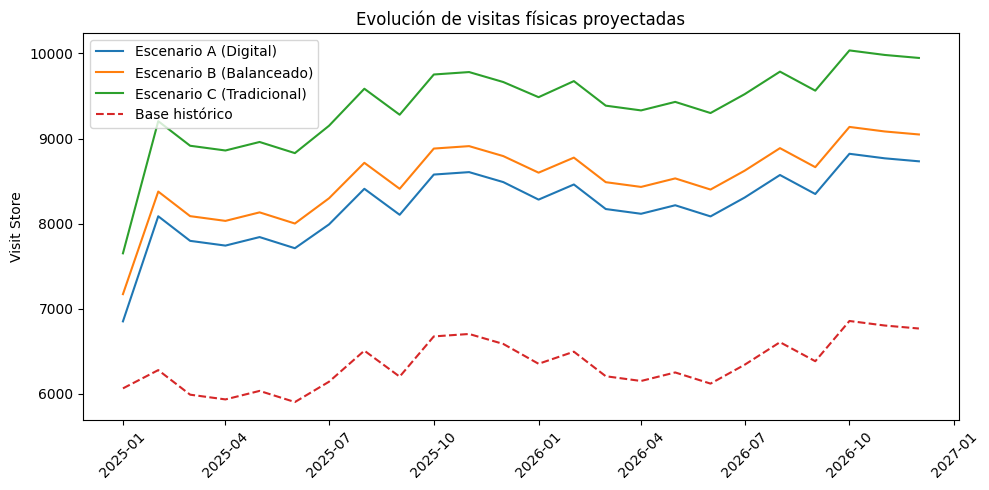

In [69]:
# Crear gráfico comparativo de visitas.
plt.figure(figsize=(10, 5))
plt.plot(df_futuro.index, df_futuro["Visit_Store_PRED_A"], label="Escenario A (Digital)")
plt.plot(df_futuro.index, df_futuro["Visit_Store_PRED_B"], label="Escenario B (Balanceado)")
plt.plot(df_futuro.index, df_futuro["Visit_Store_PRED_C"], label="Escenario C (Tradicional)")
plt.plot(df_futuro.index, df_futuro["Visit_Store"], label="Base histórico", linestyle="--")
plt.title("Evolución de visitas físicas proyectadas")
plt.ylabel("Visit Store")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

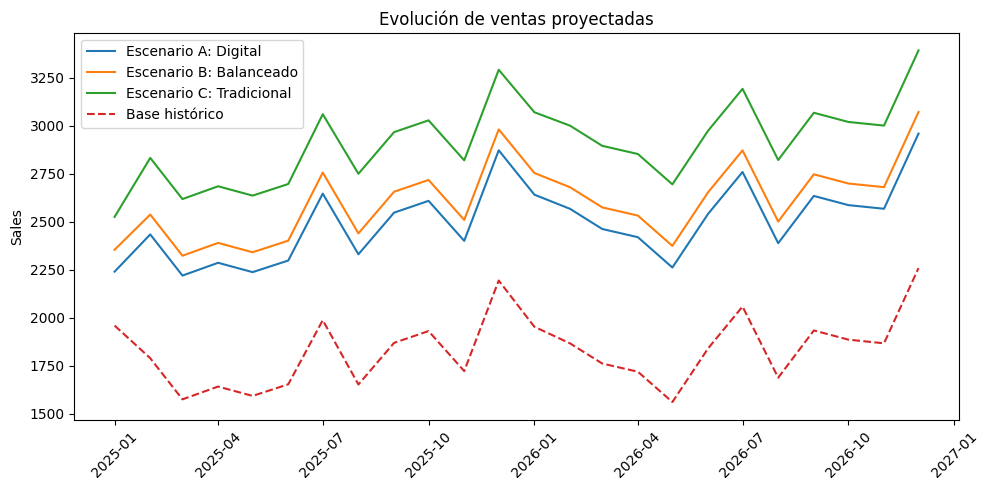

In [70]:
# crear gráfico comparativo de ventas.
plt.figure(figsize=(10, 5))
plt.plot(df_futuro.index, df_futuro["Sales_PRED_A"], label="Escenario A: Digital")
plt.plot(df_futuro.index, df_futuro["Sales_PRED_B"], label="Escenario B: Balanceado")
plt.plot(df_futuro.index, df_futuro["Sales_PRED_C"], label="Escenario C: Tradicional")
plt.plot(df_futuro.index, df_futuro["Sales"], label="Base histórico", linestyle="--")
plt.title("Evolución de ventas proyectadas")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

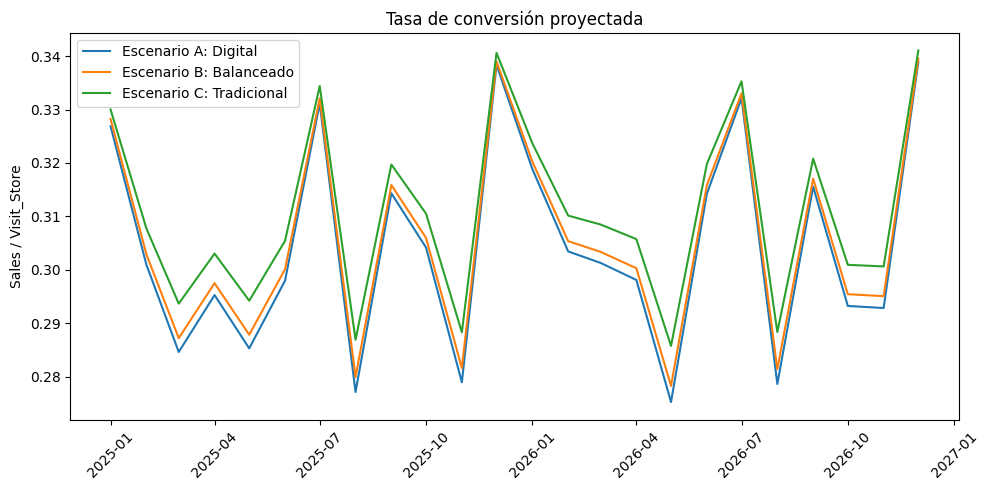

In [71]:
# Crear gráfico comparativo de tasa de conversión.
plt.figure(figsize=(10, 5))
plt.plot(df_futuro.index, df_futuro["Tasa_conversion_A"], label="Escenario A: Digital")
plt.plot(df_futuro.index, df_futuro["Tasa_conversion_B"], label="Escenario B: Balanceado")
plt.plot(df_futuro.index, df_futuro["Tasa_conversion_C"], label="Escenario C: Tradicional")
plt.title("Tasa de conversión proyectada")
plt.ylabel("Sales / Visit_Store")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Tras la simulación completa de los tres escenarios de distribución publicitaria —Digital (A), Balanceado (B) y Tradicional (C)— y el análisis de sus resultados en términos de visitas físicas, ventas estimadas y eficiencia de conversión, se identifican diferencias clave que permiten orientar la estrategia futura de inversión.

Aunque el escenario **C (Tradicional dominante)** ofrece los mayores volúmenes absolutos de visitas y ventas, también implica una mayor concentración de recursos en medios offline, lo que puede limitar la flexibilidad y elevar los costes. Por su parte, el escenario **A (Digital)** se muestra como una alternativa más escalable y económica, pero con menor conversión y retorno inmediato.

En este contexto, el escenario **B (Balanceado)** se posiciona como la **opción más recomendable** al ofrecer un equilibrio óptimo entre volumen, eficiencia y estabilidad. Este reparto permite mantener un buen rendimiento comercial sin sobrecargar ningún canal específico, y ofrece una base flexible desde la cual seguir iterando estrategias o realizar optimizaciones futuras.

> Si el objetivo es **maximizar resultados sin comprometer la eficiencia**, y dejar margen para ajustar o escalar en función del rendimiento real, el **escenario B (Balanceado)** representa la mejor opción inicial para la planificación de campañas y la toma de decisiones estratégicas.

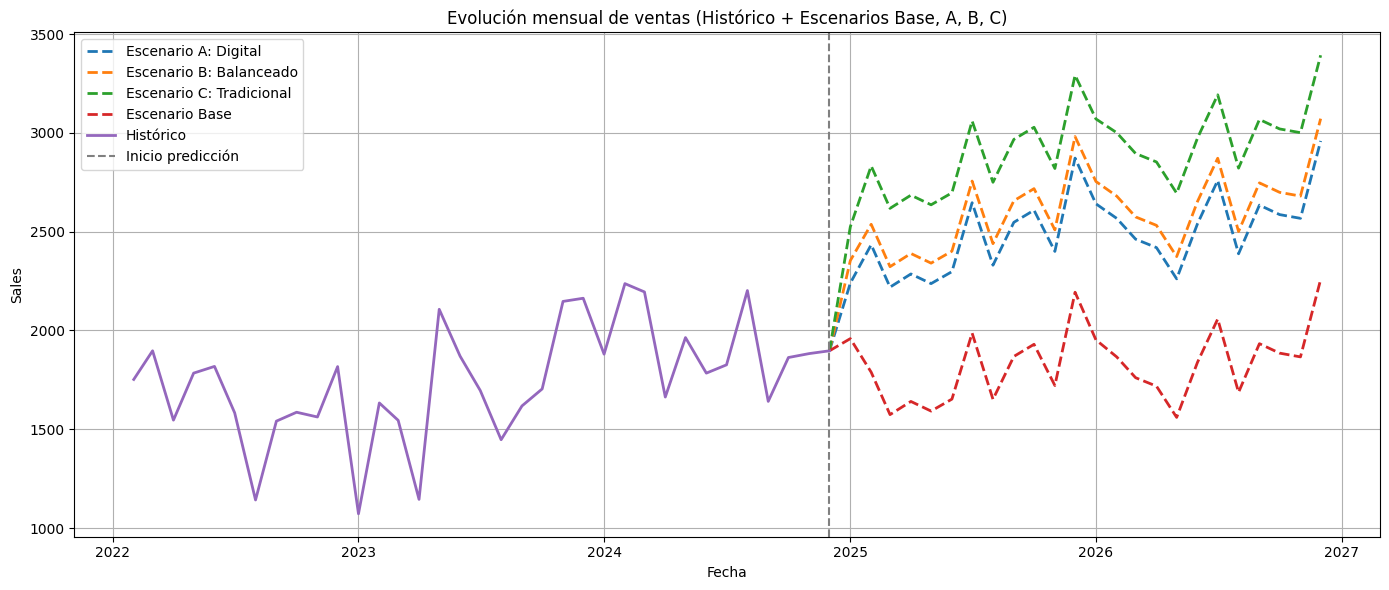

In [72]:
# Gráfico de comparación entre diferentes escenarios de ventas.
ultimo_valor_hist = df_historico_sales.iloc[[-1]].copy()

# Escenario base.
df_futuro_base = pd.concat([
    ultimo_valor_hist.rename(columns={"Sales": "Sales"}),
    df_futuro[["Sales"]].copy()
])
df_futuro_base["Escenario"] = "Escenario Base"

# Escenarios.
df_futuro_A = pd.concat([
    ultimo_valor_hist.rename(columns={"Sales": "Sales"}),
    df_futuro[["Sales_PRED_A"]].rename(columns={"Sales_PRED_A": "Sales"})])
df_futuro_A["Escenario"] = "Escenario A: Digital"

df_futuro_B = pd.concat([ultimo_valor_hist.rename(columns={"Sales": "Sales"}),
    df_futuro[["Sales_PRED_B"]].rename(columns={"Sales_PRED_B": "Sales"})])
df_futuro_B["Escenario"] = "Escenario B: Balanceado"

df_futuro_C = pd.concat([ultimo_valor_hist.rename(columns={"Sales": "Sales"}),
    df_futuro[["Sales_PRED_C"]].rename(columns={"Sales_PRED_C": "Sales"})])
df_futuro_C["Escenario"] = "Escenario C: Tradicional"

# Histórico.
df_historico_sales["Escenario"] = "Histórico"

df_total_sales = pd.concat([
    df_historico_sales, df_futuro_base, df_futuro_A, df_futuro_B, df_futuro_C
])
orden_escenarios = ["Escenario A: Digital", "Escenario B: Balanceado",
                    "Escenario C: Tradicional","Escenario Base", "Histórico"
]


plt.figure(figsize=(14, 6))
for escenario in orden_escenarios:
    datos = df_total_sales[df_total_sales["Escenario"] == escenario]
    estilo = '-' if escenario == "Histórico" else '--'
    plt.plot(datos.index, datos["Sales"],
             label=escenario,
             linestyle=estilo,
             linewidth=2)
plt.axvline(df_historico_sales.index.max(), linestyle="--", color="gray", label="Inicio predicción")
plt.title("Evolución mensual de ventas (Histórico + Escenarios Base, A, B, C)")
plt.xlabel("Fecha")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Conclusión: Comparativa y elección de escenario óptimo.**

Tras simular tres estrategias diferenciadas de inversión publicitaria —**Digital (A)**, **Balanceado (B)** y **Tradicional (C)**— y aplicar los modelos predictivos sobre visitas físicas (`Visit Store`) y ventas estimadas (`Sales`), se ha llevado a cabo un análisis comparativo que permite tomar decisiones estratégicas basadas en datos.

Los resultados muestran patrones consistentes:

- El **escenario C**, centrado en medios tradicionales, genera el **mayor volumen absoluto de visitas y ventas**, pero a costa de una mayor concentración de presupuesto en canales offline, lo que podría comprometer la eficiencia y escalabilidad en el largo plazo.

- El **escenario A**, orientado a canales digitales, es el **más económico y flexible**, pero presenta el **menor rendimiento en conversión y resultados finales**, lo cual puede limitar su efectividad si el objetivo es maximizar retorno inmediato en tienda.

- El **escenario B**, con un reparto equilibrado de la inversión entre canales, ofrece **el mejor compromiso entre volumen, eficiencia y estabilidad**. Muestra una conversión robusta, un rendimiento comercial sólido y una estructura presupuestaria racional que facilita tanto el control como la optimización futura.


**Elección recomendada.**

En función de estos hallazgos, se recomienda adoptar el **escenario B (Balanceado)** como base estratégica para futuras campañas. Esta combinación permite:

- Obtener resultados consistentes y competitivos sin depender exclusivamente de un solo canal.
- Mantener la flexibilidad necesaria para ajustes tácticos según la respuesta del mercado.
- Optimizar la eficiencia presupuestaria sin sacrificar el impacto comercial.

> El escenario B no solo responde a los objetivos actuales de rendimiento y control de inversión, sino que también establece un punto de partida óptimo para futuros procesos de testeo, redistribución del mix y optimización continua de campañas publicitarias.

### **Análisis del escenario B: Inversión Balanceada.**
Este subapartado se dedica a explorar en profundidad el comportamiento del **escenario B**, definido por un reparto equilibrado del presupuesto publicitario:
**40 % en medios digitales**, **45 % en medios tradicionales (offline)** y **15 % en producción y gastos complementarios**.

La simulación se ha aplicado sobre los próximos 24 meses, utilizando los modelos entrenados en fases anteriores para predecir tanto las visitas físicas (`Visit Store`) como las ventas (`Sales`) bajo estas condiciones de inversión.

- El escenario B ofrece un **rendimiento comercial sólido y estable** a lo largo de todo el periodo simulado.
- El modelo refleja una **tasa de conversión consistente**, con una buena relación entre tráfico web, visitas físicas y ventas mensuales.
- Se observan picos esperables durante periodos promocionales clave (Navidad, Rebajas o fin de mes), lo cual valida la lógica del modelo.

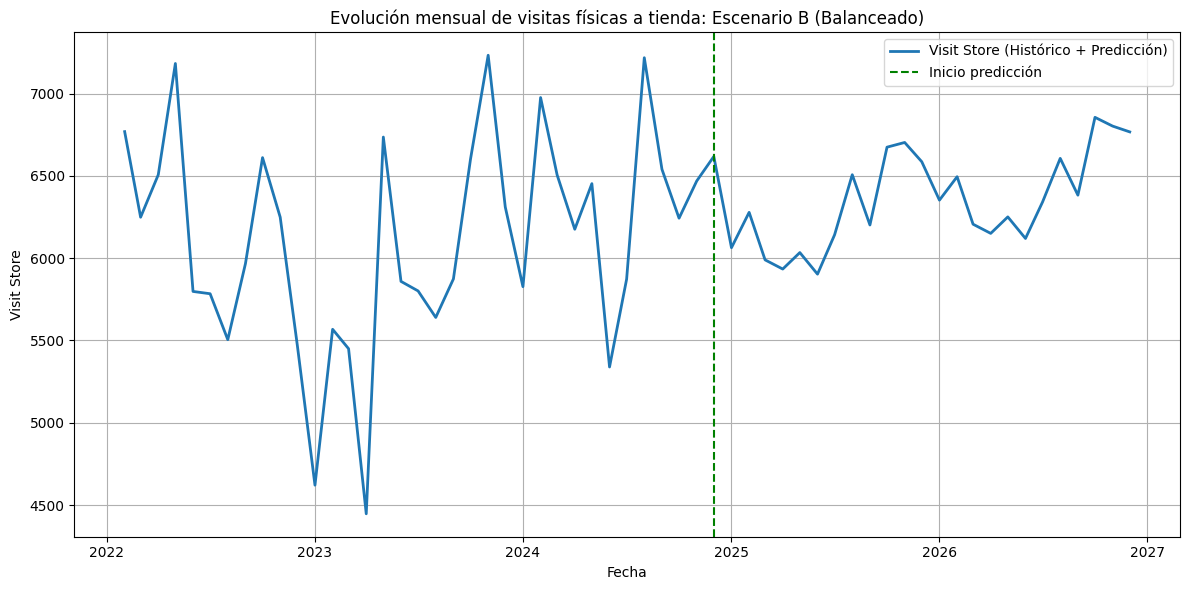

In [73]:
# Visualización de evolución mensual.
df_historico_visitas = df[["Visit_Store"]].copy()
df_futuro_sales = df_futuro[["Visit_Store_PRED_B"]].rename(columns={"Visit_Store_PRED_B": "Sales"}).copy()

df_total_visitas = pd.concat([df_historico_visitas, df_futuro_visitas])

plt.figure(figsize=(12, 6))
plt.plot(df_total_visitas.index, df_total_visitas["Visit_Store"], label="Visit Store (Histórico + Predicción)", linewidth=2)
plt.axvline(df_historico_visitas.index.max(), color="green", linestyle="--", label="Inicio predicción")
plt.title("Evolución mensual de visitas físicas a tienda: Escenario B (Balanceado)")
plt.xlabel("Fecha")
plt.ylabel("Visit Store")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

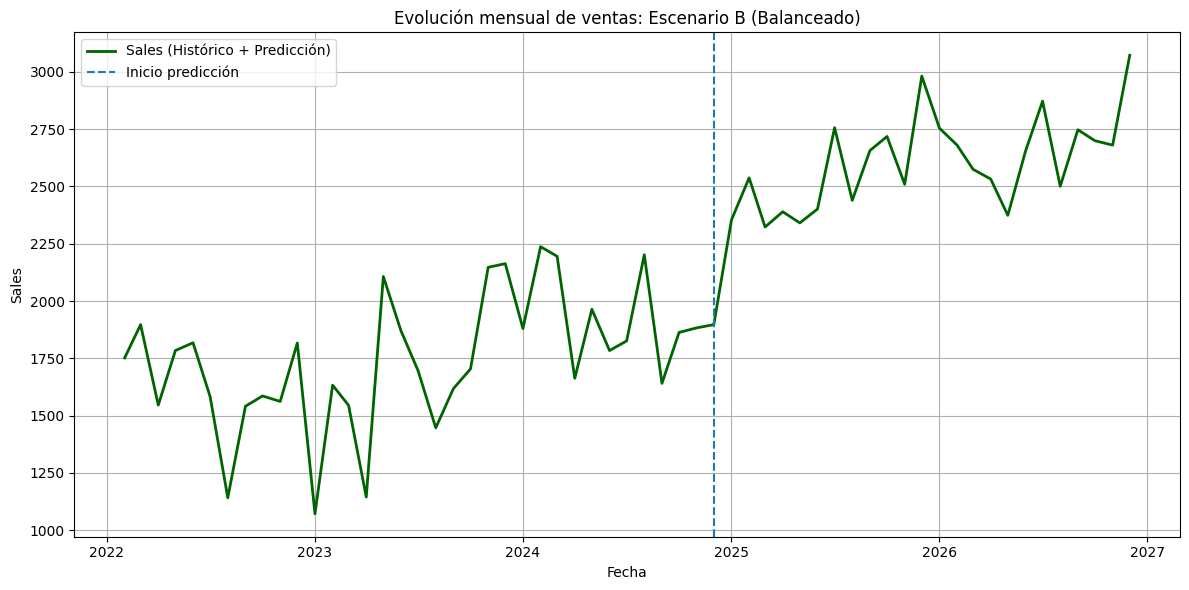

In [74]:
# Visualización de evolución mensual.
df_historico_sales = df[["Sales"]].copy()
df_futuro_sales = df_futuro[["Sales_PRED_B"]].rename(columns={"Sales_PRED_B": "Sales"}).copy()
df_total = pd.concat([df_historico_sales, df_futuro_sales])

plt.figure(figsize=(12, 6))
plt.plot(df_total.index, df_total["Sales"], label="Sales (Histórico + Predicción)", linewidth=2, color="darkgreen")
plt.axvline(df_historico_sales.index.max(), linestyle="--", label="Inicio predicción")
plt.title("Evolución mensual de ventas: Escenario B (Balanceado)")
plt.xlabel("Fecha")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

La evolución mensual de ventas bajo el escenario de inversión balanceada muestra una **tendencia de crecimiento sostenido y progresivo** tras el punto de inicio de la predicción. Este comportamiento confirma que una distribución equilibrada del presupuesto entre canales online y offline permite maximizar el rendimiento sin sacrificar estabilidad. Es un escenario óptimo para construir estrategias escalables y adaptables en el tiempo.